# Import libraries, Load Data

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime


In [75]:
# Paths:

price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
#price_path = "C:/Users/lukee/Downloads/price_data_from_shardar.csv"
#cap_path = "C:/Users/lukee/Downloads/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [76]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


# Outline and Function Definitions

### Functions

In [77]:
# Function to find the top ten largest market cap stocks
def find_top_ten(dataframe, date_start, date_end):
    target_date = date_end + 1
    selected_row = caps_df.iloc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(10).index.tolist()
    return stocks_list

In [78]:
# Function to check for null values
def check_top_ten(dataframe, date_start, date_end, stocks_list):
    #should find the average and median ammount of null values per column
    #print this out and print out top ten col's ammounts
    ammount_null = []
    for column in df.columns:
        num_null = df[column].isnull().sum()
        ammount_null.append(num_null)
    average_num_null = np.mean(ammount_null)
    median_num_null = np.median(ammount_null)
    plt.boxplot(ammount_null, vert=False)
    plt.title('Boxplot of null values per stock in time period')
    plt.show()
    print("Checking Stocks List")
    print("--------------------")
    for column in stocks_list:
        num_null = df[column].isnull().sum()
        print(f'Stock: {column}, Num null: {num_null}')

In [79]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    #print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    # print("Filtered diff df len (before dropna):", len(filtered_df))
    # print(filtered_df.head())
    # print(len(filtered_df))
    # print(filtered_df.isnull().sum())
    filtered_df = filtered_df.dropna()
    # print("Filtered diff df len (after dropna):", len(filtered_df))
    # print(len(filtered_df))
    return filtered_df

In [80]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [81]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [82]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [83]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    #print(f'A Shape: {A.shape}')
    D = np.diag(A.sum(axis=1))
    #print(f'D Shape: {D.shape}')
    L = D - A
    #print(f'L Shape: {L.shape}')
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    #print(f'X Shape: {X.shape}')
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    #print("Kmeans Labels:")
    #print(kmeans.labels_)
    #print(df.columns)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict


In [84]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [85]:
# Function to check on existing pairs
def is_still_conintegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [86]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return beta

In [87]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    order = []
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
        order = [asst1, asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
        order = [asst2, asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, order, mean
    

In [88]:
def print_spread_charts(data_series, upper_bound, lower_bound, mean_value, pair_name):
    # Extract dates and values
    dates = data_series.index
    values = data_series.values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    
    # Plot the average line
    plt.axhline(y=mean_value, color='blue', linestyle='-', linewidth=1, label='Mean')
    
    # Plot the dashed lines for ±2 standard deviations
    plt.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
    plt.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
    
    # Plot the individual data points
    plt.scatter(dates, values, color='black', zorder=5)
    
    # Annotate the plot
    plt.title(f'Spread: {pair_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()

In [89]:
def monitor_pair_for_week(dataframe, start_date_index, end_date_index, curr_week_start_index, pair, pair_vals_list):
    # Format for pair_vals_list:
    #[ still_consecutive, [start_dates], [end_date], [[days_to_open_trade]] ]
    global prices_with_market
    # print(f"In monitor pair for week, Pair {pair[0], pair[1]}")
    start_date_string = prices_with_market.index[start_date_index].strftime('%Y-%m-%d')
    end_date_string = prices_with_market.index[end_date_index].strftime('%Y-%m-%d')
    curr_week_date_string = prices_with_market.index[curr_week_start_index].strftime('%Y-%m-%d')
        
    forward_three_months_data = prices_with_market[start_date_index+7 : end_date_index]
    nulls_in_three_months_for_stock1 = forward_three_months_data[pair[0]].isnull().sum()
    nulls_in_three_months_for_stock2 = forward_three_months_data[pair[1]].isnull().sum()
    
    if nulls_in_three_months_for_stock1 > 0 or nulls_in_three_months_for_stock2 > 0:
        if pair_vals_list[0] == True:
            # Add end date
            pair_vals_list[2].append(curr_week_date_string)
            pair_vals_list[0] = False
        return pair_vals_list
        
    if pair_vals_list[0] == True:
        past_three_month_data = prices_with_market[start_date_index : curr_week_start_index]
        # print(past_three_month_data[[pair[0], pair[1]]].head())
        beta_past_three_months = calculate_beta_for_pair(past_three_month_data, pair)
        upper, lower , pair_order, mean_val = get_spread_limits_for_past_months(past_three_month_data, pair, beta_past_three_months)
        curr_week_data = dataframe.tail(7)
        curr_week_spread_data = curr_week_data[pair_order[0]]-beta_past_three_months*curr_week_data[pair_order[1]]
        have_days_to_trade = False
        for index, value in zip(curr_week_spread_data.index, curr_week_spread_data.values):
            date = index.strftime('%Y-%m-%d')
            if (value >= upper or value <= lower):
                pair_vals_list[-1][-1].append(date)
                have_days_to_trade = True
        if have_days_to_trade:
            print_spread_charts(curr_week_spread_data, upper, lower, mean_val, pair)
            
    is_coint = is_still_conintegrated(forward_three_months_data, pair , sig_level=0.05)

    if is_coint:
        if pair_vals_list[0] == False:
            pair_vals_list[1].append(curr_week_date_string)
            pair_vals_list[-1].append([])
            pair_vals_list[0] = True
    else:
        if pair_vals_list[0] == True:
            pair_vals_list[0] = False
            pair_vals_list[2].append(curr_week_date_string)

    return pair_vals_list

# start date ['2000-03-02', '2000-05-07']
# end date ['2000-03-28', '']
# trading days [ ['2000-03-15'], []]

In [90]:
def monitor_group_of_pairs(dataframe, pair_dict, stop_after_weeks):
    coint_dict = pair_dict.copy()
    weeks_running = 0
    while(weeks_running < stop_after_weeks):
        print(f"---------------------------- WEEKS RUNNING {weeks_running + 1} -------------------------------------")
        # On the first week we don't have any previous data in the pair_dict What do we pass in??? 
        start_date_index = ((weeks_running+1)*7)
        # always add 89 days here
        end_date_index = ((weeks_running+1)*7) + 97

        curr_week_start_index = ((weeks_running+1)*7) + 89
        # Filter the overall df
        three_month_plus_one_week_df = dataframe[start_date_index : end_date_index]
        for key, value in coint_dict.items():
            # end_date = start_date + WEEK            
            result = monitor_pair_for_week(three_month_plus_one_week_df, start_date_index, end_date_index, curr_week_start_index, key, value )
            # Update pair_dict[pair] with result
            coint_dict[key] = result
        # Prepping for the next week...
        
        # Finding the new cointegrated pairs
        new_top_ten_stocks = find_top_ten(prices_with_market, (start_date_index+7) , (end_date_index))
        # monitoring_data = filter_diff_df(prices_with_market, (start_date_index+7) , (end_date_index), new_top_ten_stocks)
        diff_df = filter_diff_df(prices_with_market, (start_date_index+7) , (end_date_index), new_top_ten_stocks)
        # print(f'Monitoring data: {len(monitoring_data)}')
        # filtered_monitoring_data = filter_df_by_dates(prices_with_market, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        three_month_top_10_price_df = filter_df_by_dates(prices_with_market, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        # print(f'Filtered Monitoring data: {len(filtered_monitoring_data)}')
        beta_df = calculate_betas(diff_df, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        # print(f'beta data: {len(beta_df)}')
        # print("-------------------------")

        merged_df = diff_df.merge(beta_df, how = 'cross')
        res_df = calculate_residuals(merged_df, new_top_ten_stocks)
        cluster_dict = cluster_the_matrix(res_df, 5)
        pairs = find_cointegrated_pairs(three_month_top_10_price_df, cluster_dict, 0.05)
        print(f"Pairs found: {pairs}")
        default_val_list_for_new_pair = [True, [dataframe.index[start_date_index].strftime('%Y-%m-%d')],[],[[]]]
        for tup in pairs:
            stock1, stock2 = tup
            # print(f"stock 1: {stock1}, stock2: {stock2}")
            if ((stock1, stock2) not in coint_dict) and ((stock2, stock1) not in coint_dict):
                coint_dict[(stock1, stock2)] = default_val_list_for_new_pair
        # print(pairs)
        
        #found_pairs = find_contintegrated_pairs() 
        # for item in found_pairs:
            #if coint_dict[item] not in coint_dict:
                #otherwise add it as a new key with the default list
        weeks_running += 1
    return coint_dict

In [91]:
def print_overall_display(pairs_dictionary):
    data = pairs_dictionary

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Determine the number of plots needed
    num_keys = len(data)
    num_plots = (num_keys + 4) // 5  # Calculate the number of plots needed, rounding up

    # Iterate over the required number of plots
    for plot_index in range(num_plots):
        fig, ax = plt.subplots(figsize=(10, 5))

        start_index = plot_index * 5
        end_index = min(start_index + 5, num_keys)

        # Iterate over the data to plot
        for idx, (key, value) in enumerate(list(data.items())[start_index:end_index]):
            actual_idx = start_index + idx
            label = f"{key[0]}-{key[1]}"
        
            # Extract periods and events
            periods_start = [str_to_date(date) for date in value[1]]
            periods_end = [str_to_date(date) for date in value[2]]
            event_lists = value[3]
        
            # Plot each period as a line
            for start, end in zip(periods_start, periods_end):
                ax.plot([start, end], [idx, idx], color='black')
        
            # Plot each event as a dot
            for events in event_lists:
                event_dates = [str_to_date(date) for date in events]
                ax.plot(event_dates, [idx] * len(event_dates), 'o', color='red')

            # Add the label for the pair on the Y-axis
            #ax.text(periods_start[0], idx, label, verticalalignment='center', fontsize=12, horizontalalignment='right')

        # Formatting the plot
        ax.set_yticks(range(5))
        ax.set_yticklabels([f"{key[0]}-{key[1]}" for key, _ in list(data.items())[start_index:end_index]], fontsize=12, horizontalalignment='right')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45) 
        plt.xlabel('Date')
        plt.title(f'Event Timelines (Plot {plot_index + 1})')
        plt.tight_layout()
        plt.show()


# Testing Functions

---------------------------- WEEKS RUNNING 1 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 2 -------------------------------------
Pairs found: [('INTC', 'ORCL')]
---------------------------- WEEKS RUNNING 3 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 4 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 5 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 6 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('VIAV', 'INTC')]
---------------------------- WEEKS RUNNING 7 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('INTC', 'JNPR')]
---------------------------- WEEKS RUNNING 8 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 9 -------------------------------------
Pairs found: [('LVLT', 'DELL1')]
--------

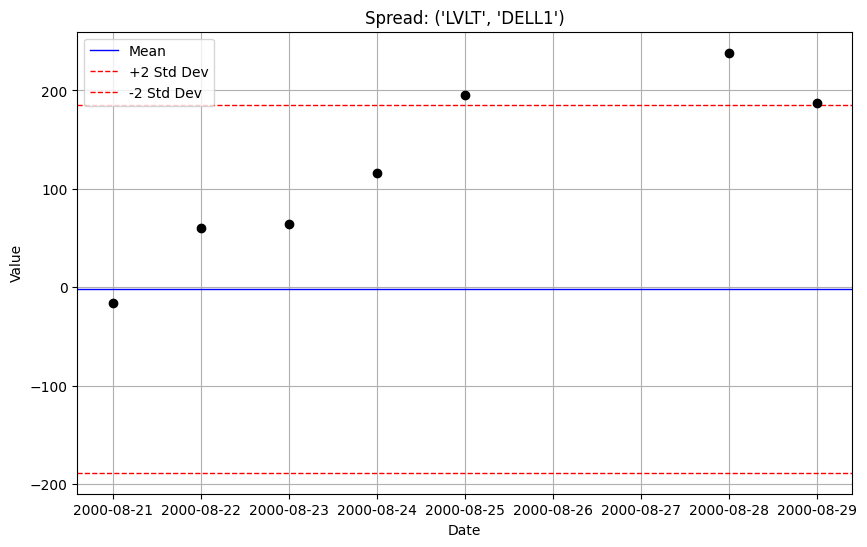

Pairs found: []
---------------------------- WEEKS RUNNING 11 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 12 -------------------------------------
Pairs found: [('CSCO', 'VIAV'), ('SDLI', 'NRTLQ')]
---------------------------- WEEKS RUNNING 13 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 14 -------------------------------------
Pairs found: [('AMCC', 'JNPR')]
---------------------------- WEEKS RUNNING 15 -------------------------------------


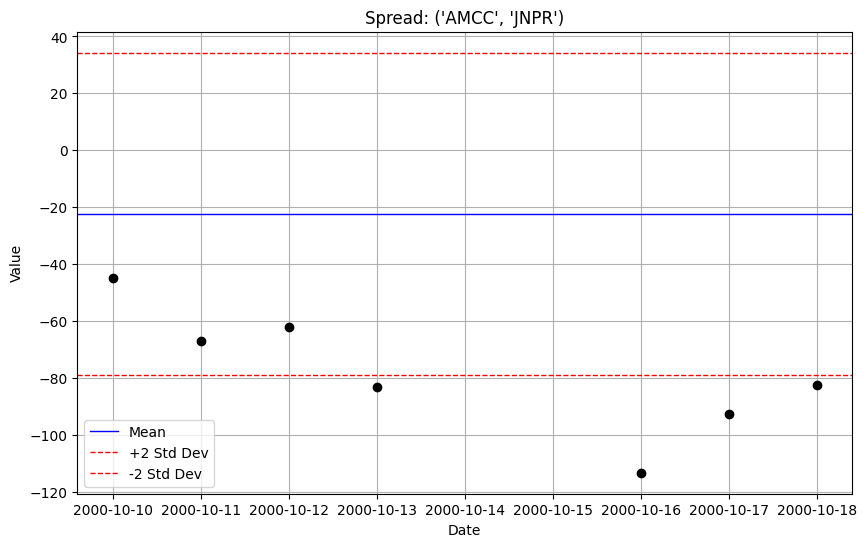

Pairs found: [('VIAV', 'CSCO')]
---------------------------- WEEKS RUNNING 16 -------------------------------------


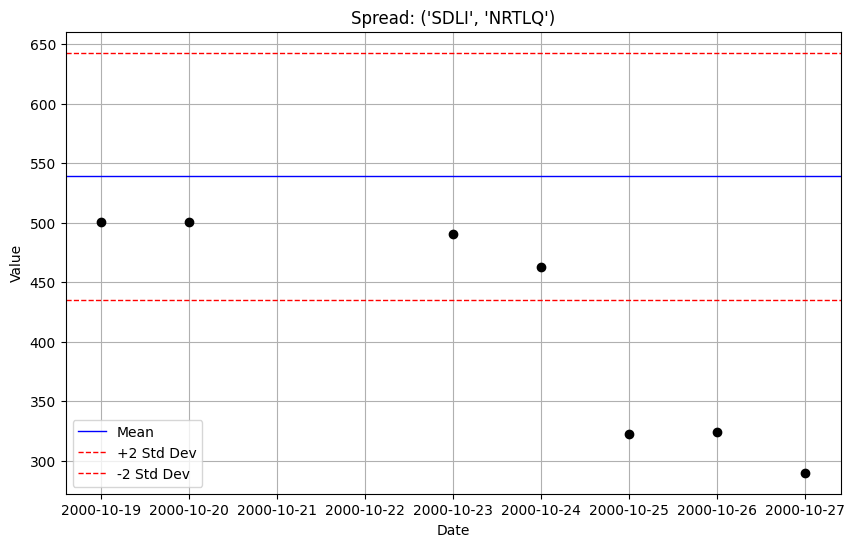

Pairs found: [('CSCO', 'VIAV')]
---------------------------- WEEKS RUNNING 17 -------------------------------------


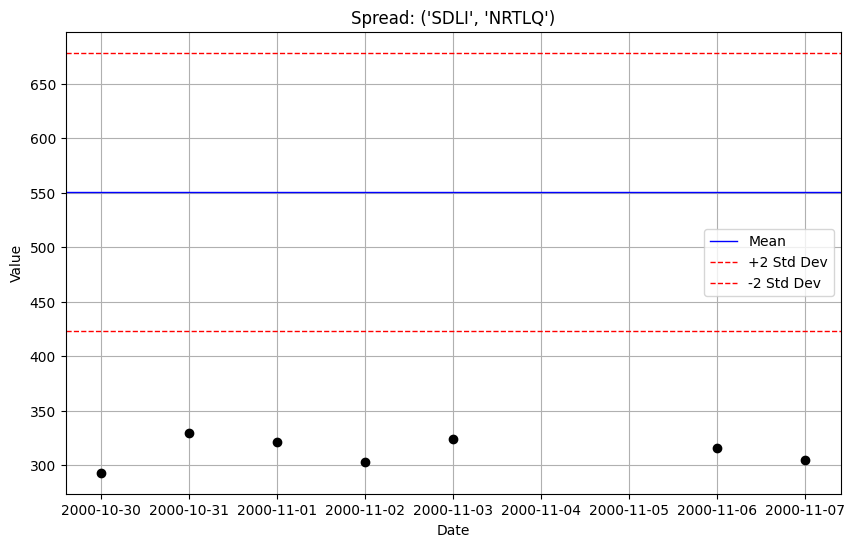

Pairs found: []
---------------------------- WEEKS RUNNING 18 -------------------------------------


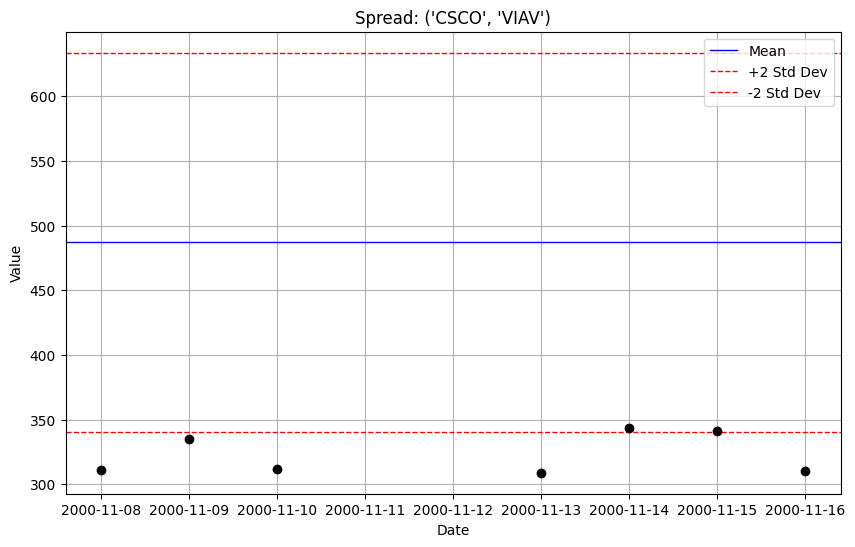

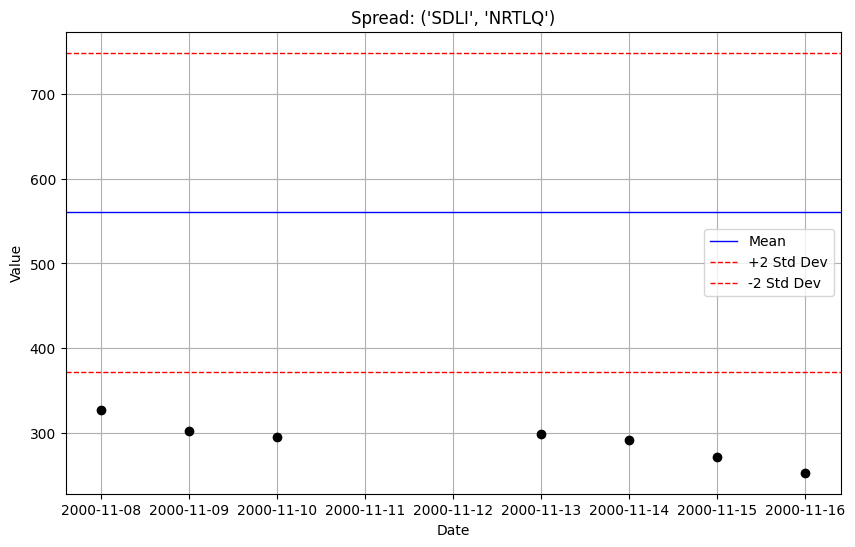

Pairs found: [('SCMR', 'CSCO'), ('SCMR', 'SDLI'), ('CSCO', 'SDLI')]
---------------------------- WEEKS RUNNING 19 -------------------------------------


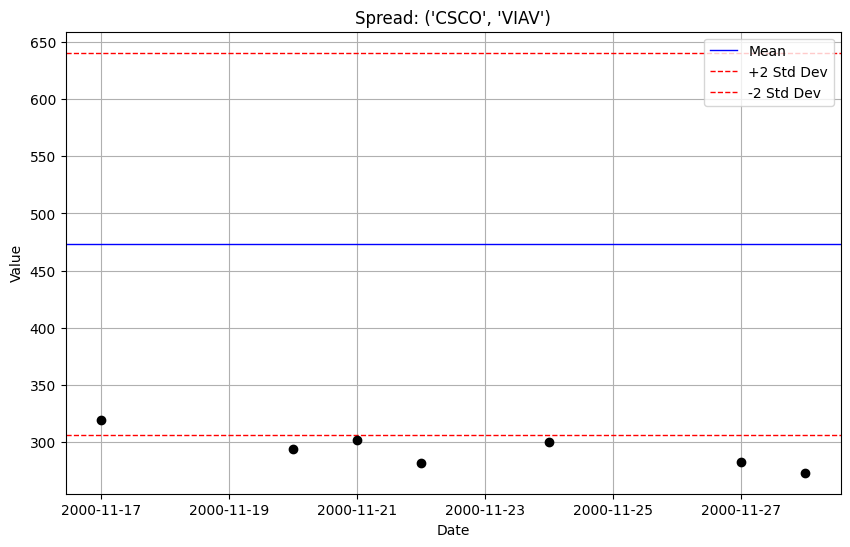

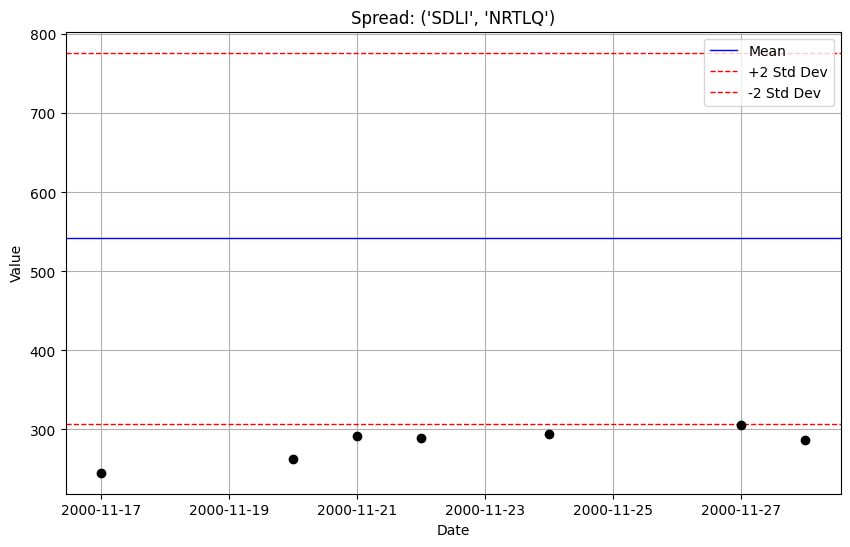

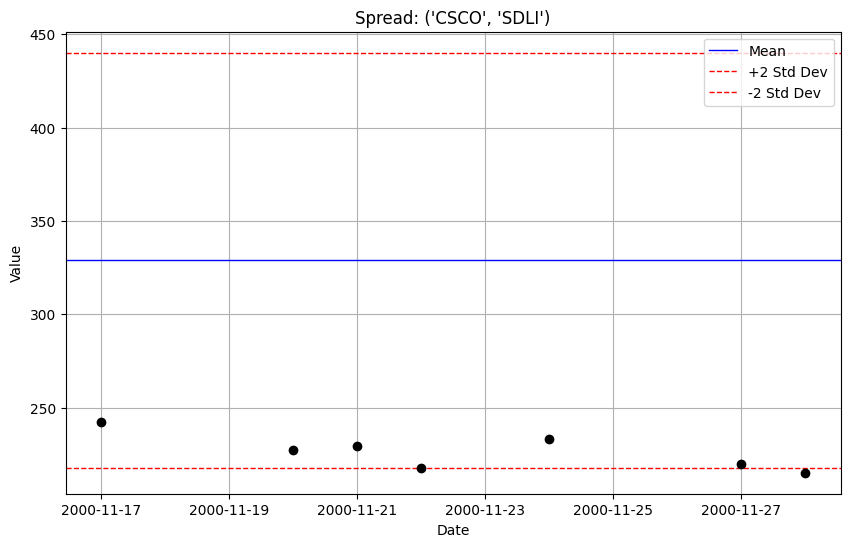

Pairs found: [('SCMR', 'SDLI'), ('BRCD', 'VRTS1')]
---------------------------- WEEKS RUNNING 20 -------------------------------------


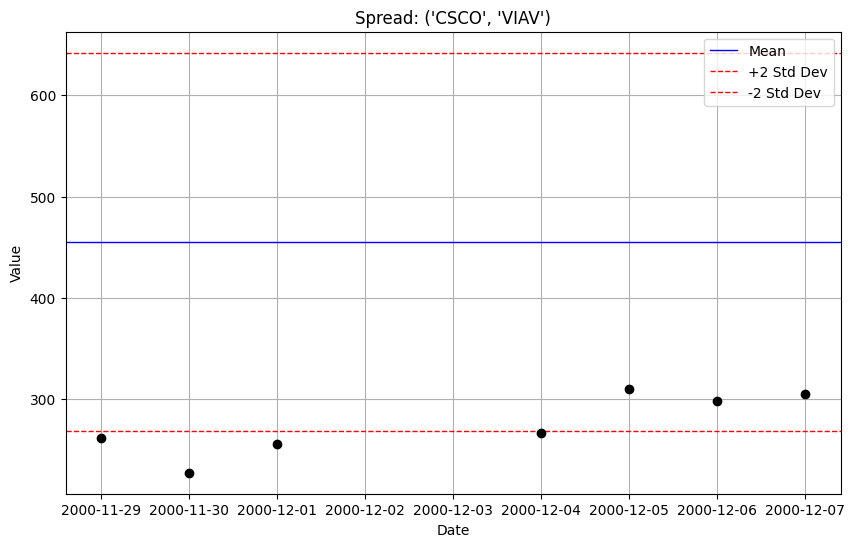

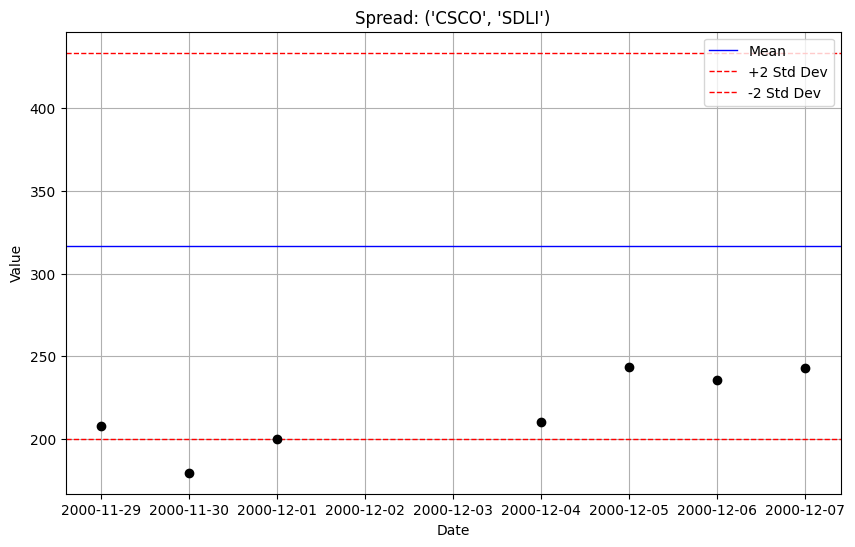

Pairs found: [('CSCO', 'SDLI')]
---------------------------- WEEKS RUNNING 21 -------------------------------------


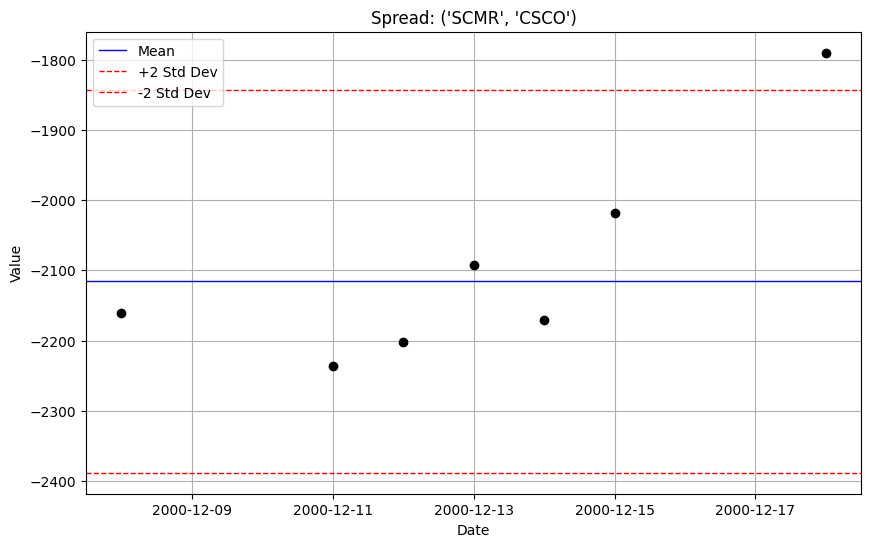

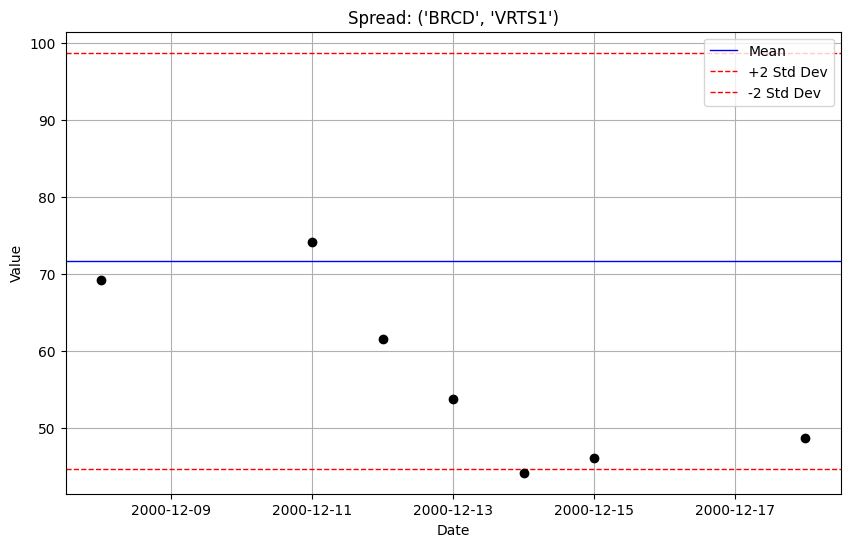

Pairs found: []
---------------------------- WEEKS RUNNING 22 -------------------------------------


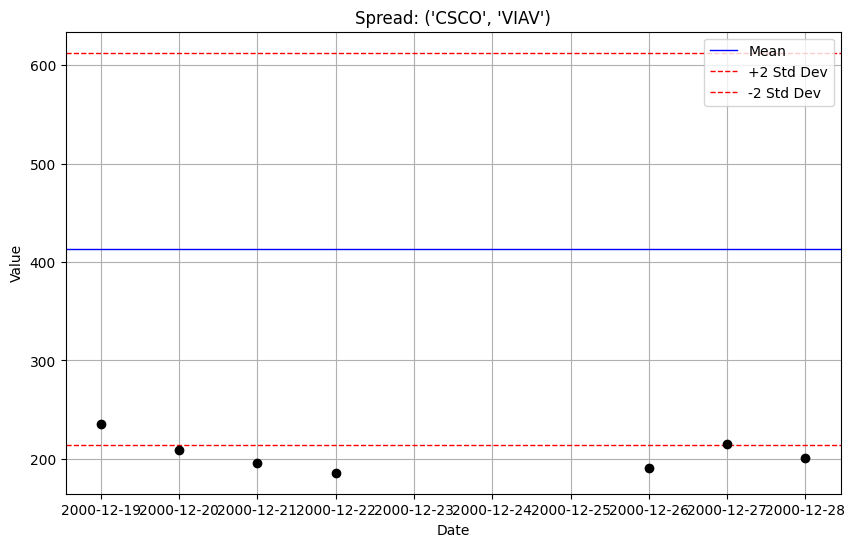

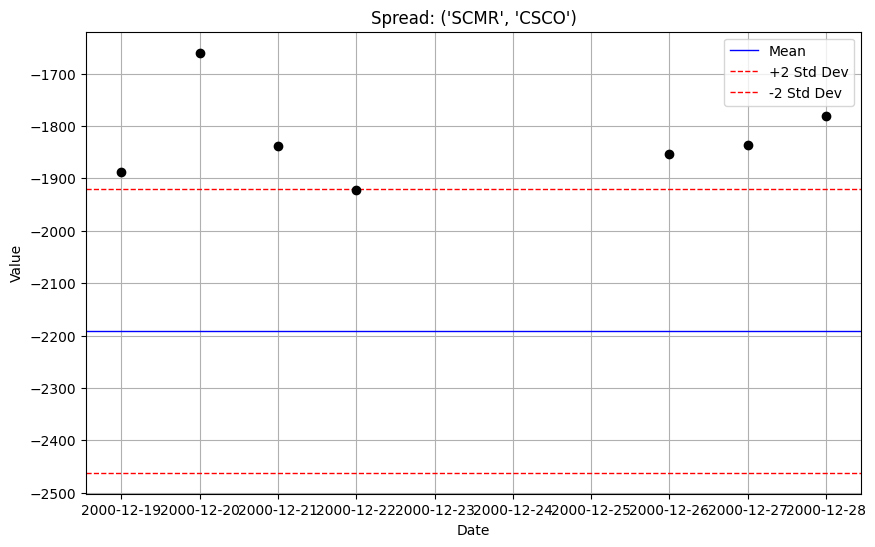

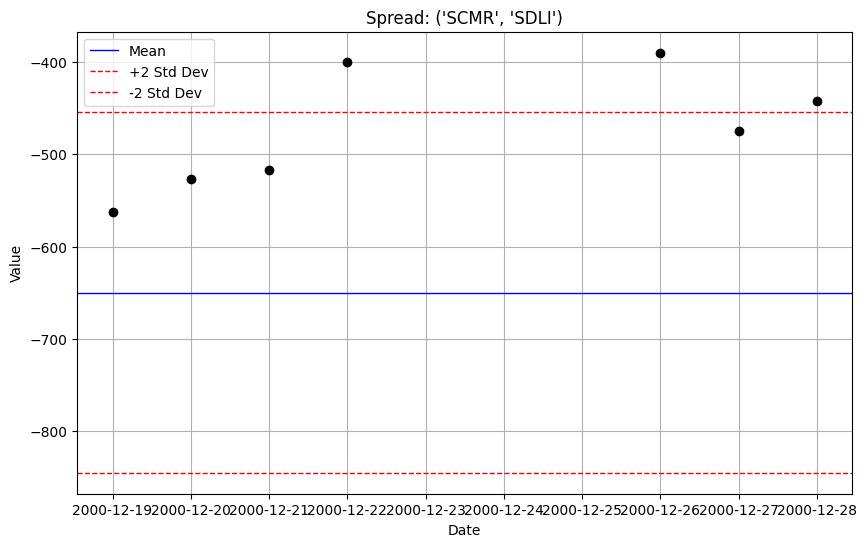

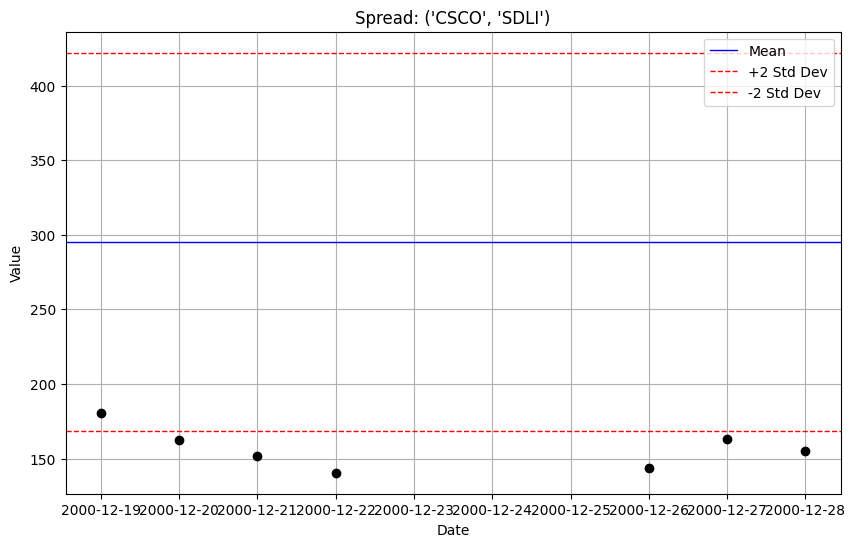

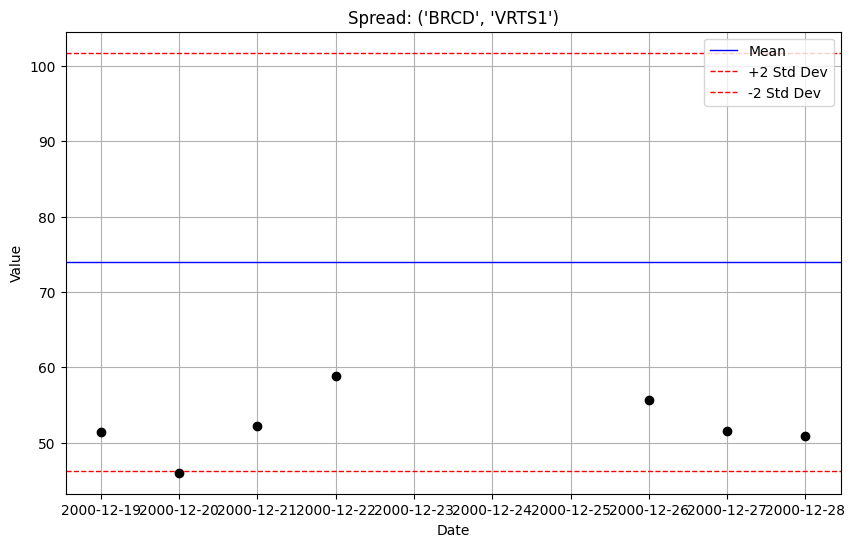

Pairs found: [('VRTS1', 'BRCD')]
---------------------------- WEEKS RUNNING 23 -------------------------------------


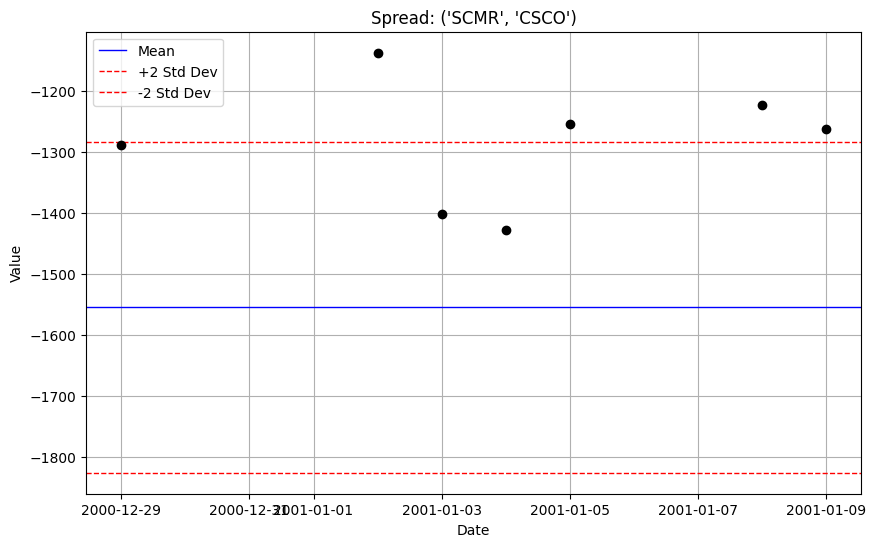

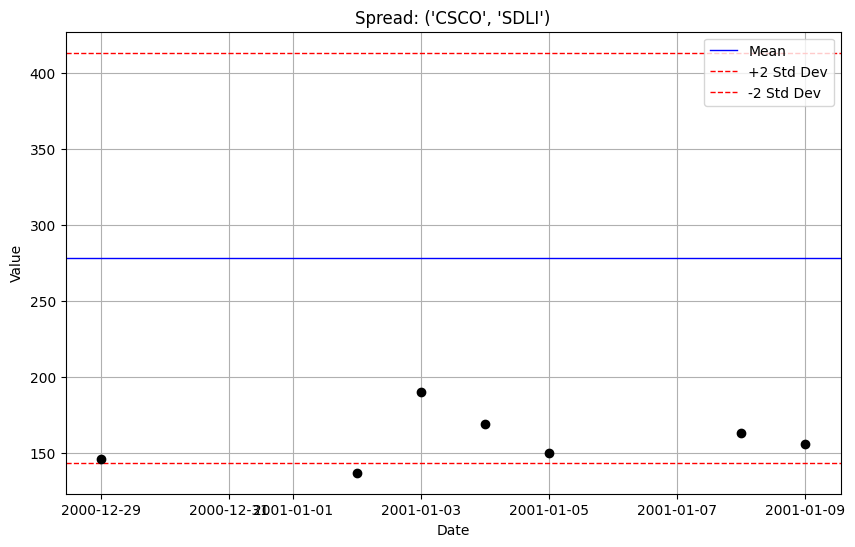

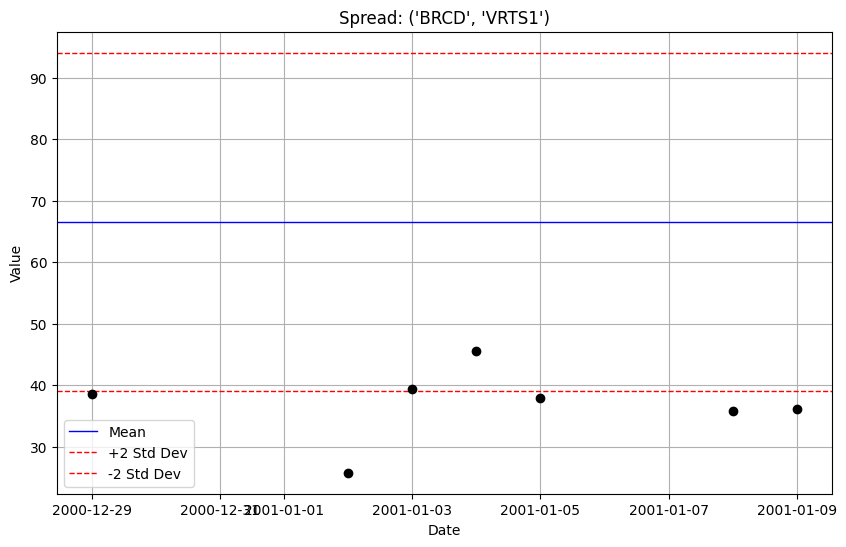

Pairs found: []
---------------------------- WEEKS RUNNING 24 -------------------------------------
Pairs found: [('JNPR', 'BRCM')]
---------------------------- WEEKS RUNNING 25 -------------------------------------
Pairs found: [('BRCM', 'NTAP')]
---------------------------- WEEKS RUNNING 26 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 27 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 28 -------------------------------------
Pairs found: [('SCMR', 'CSCO'), ('VRTS1', 'JNPR')]
---------------------------- WEEKS RUNNING 29 -------------------------------------


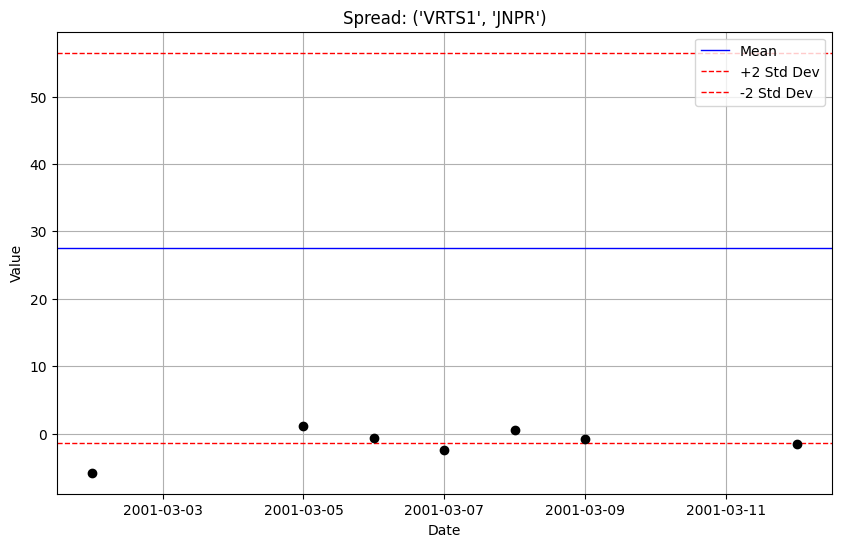

Pairs found: [('LVLT', 'CMVT'), ('VRTS1', 'JAVA1')]
---------------------------- WEEKS RUNNING 30 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 31 -------------------------------------
Pairs found: [('SCMR', 'CSCO')]
---------------------------- WEEKS RUNNING 32 -------------------------------------
Pairs found: [('SCMR', 'VRTS1'), ('CSCO', 'VRTS1'), ('VRTS1', 'EMC1')]
---------------------------- WEEKS RUNNING 33 -------------------------------------


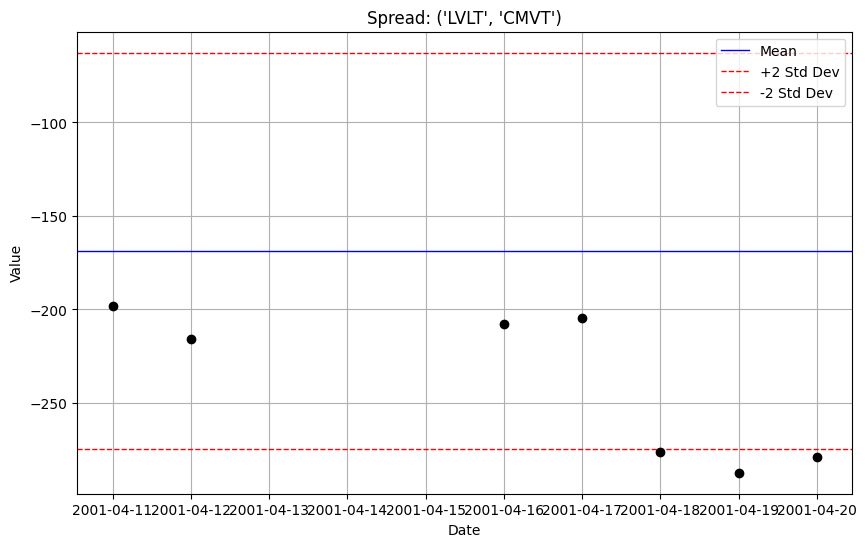

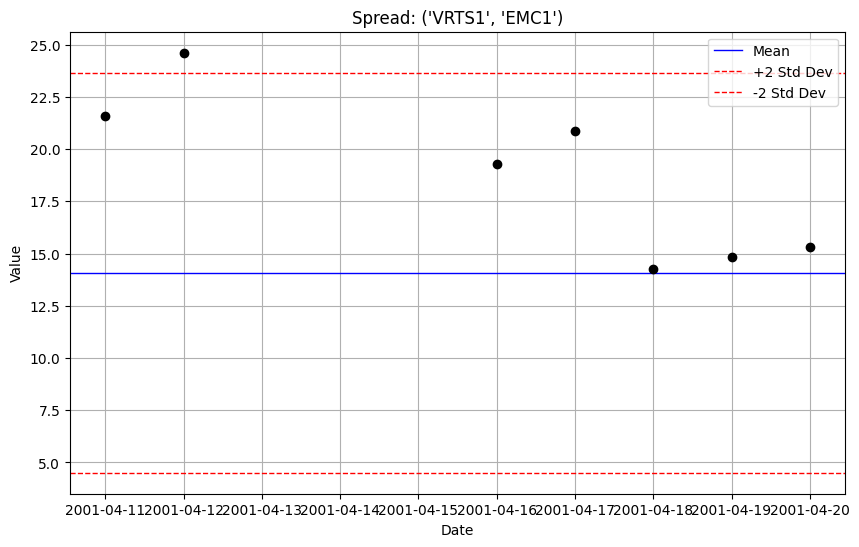

Pairs found: [('JNPR', 'VRTS1'), ('SCMR', 'CSCO'), ('VIAV', 'VRTS1'), ('CSCO', 'VRTS1')]
---------------------------- WEEKS RUNNING 34 -------------------------------------


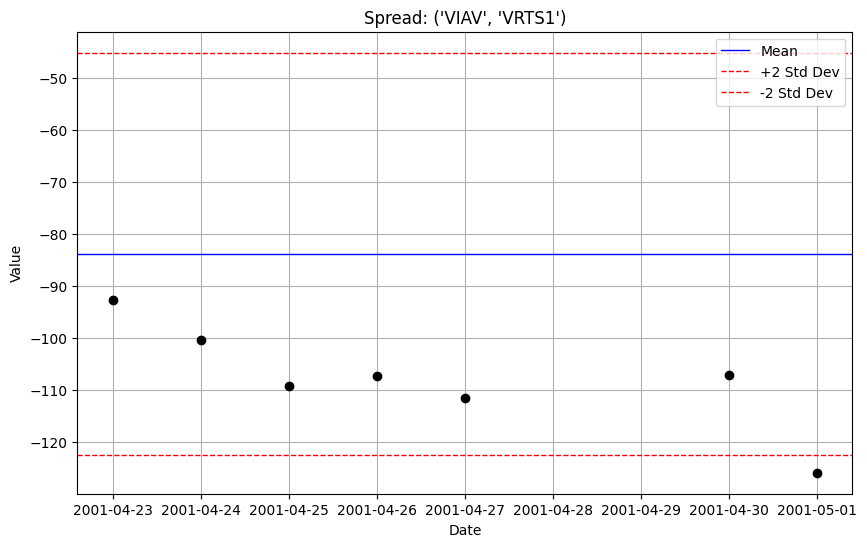

Pairs found: [('CSCO', 'VRTS1'), ('CSCO', 'JAVA1'), ('JNPR', 'VRTS1'), ('JNPR', 'JAVA1'), ('VRTS1', 'JAVA1'), ('VRTS1', 'EMC1'), ('JAVA1', 'EMC1')]
---------------------------- WEEKS RUNNING 35 -------------------------------------


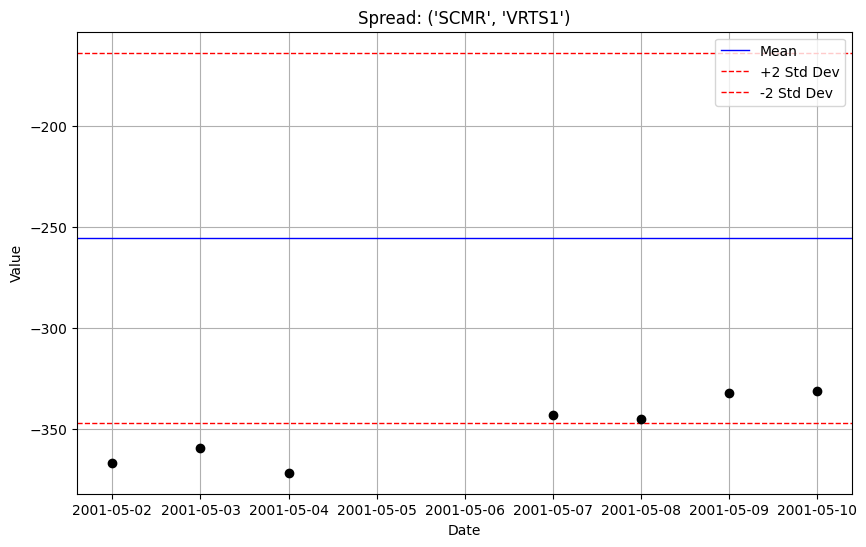

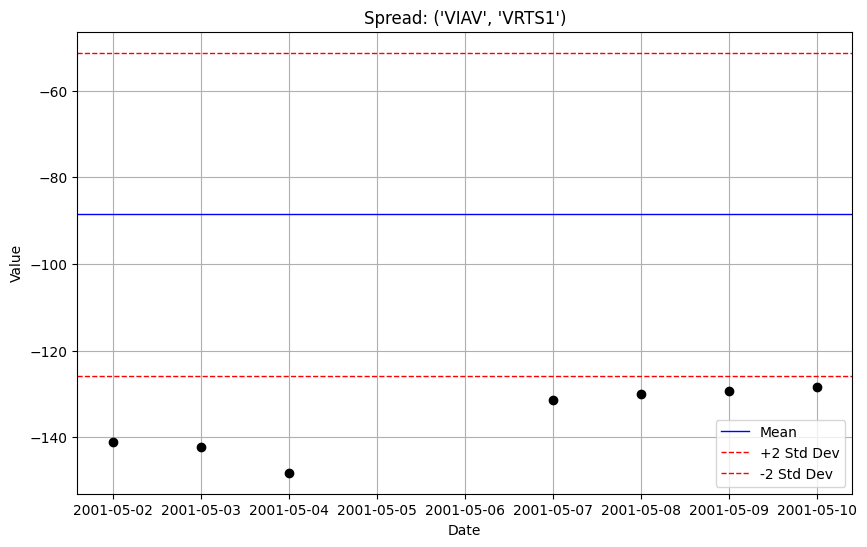

Pairs found: []
---------------------------- WEEKS RUNNING 36 -------------------------------------


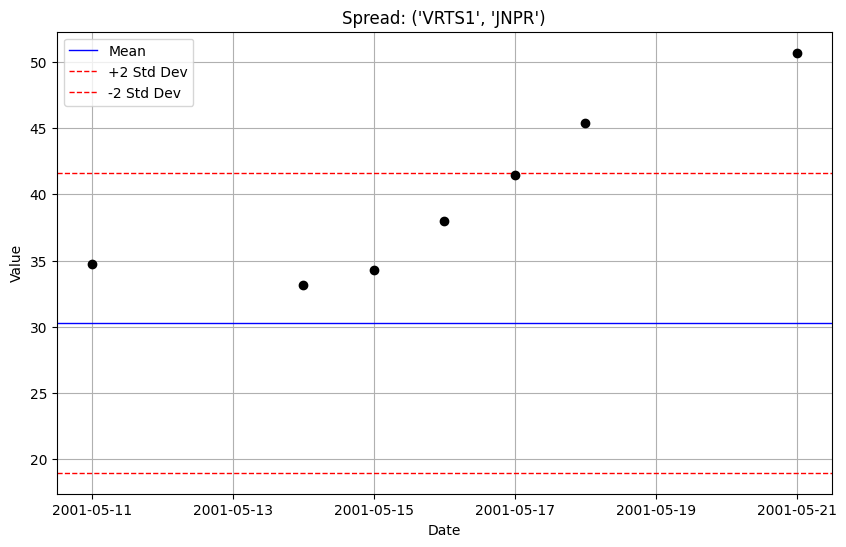

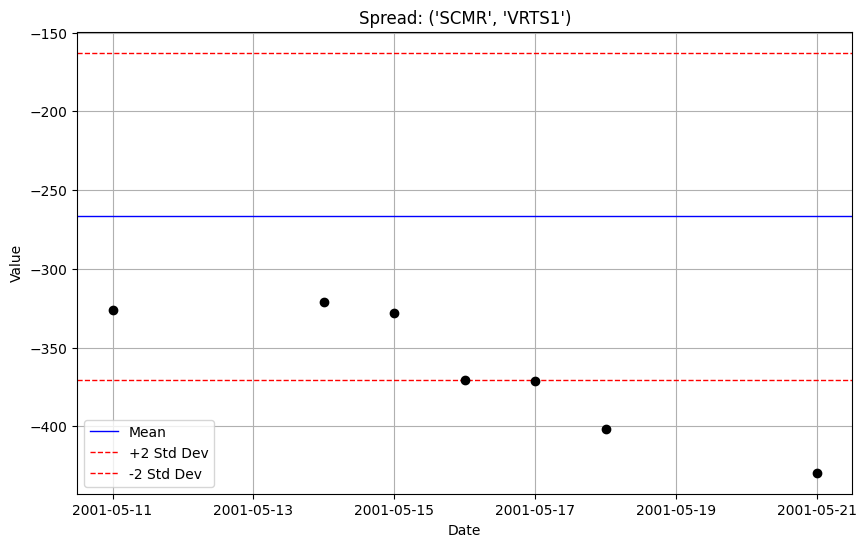

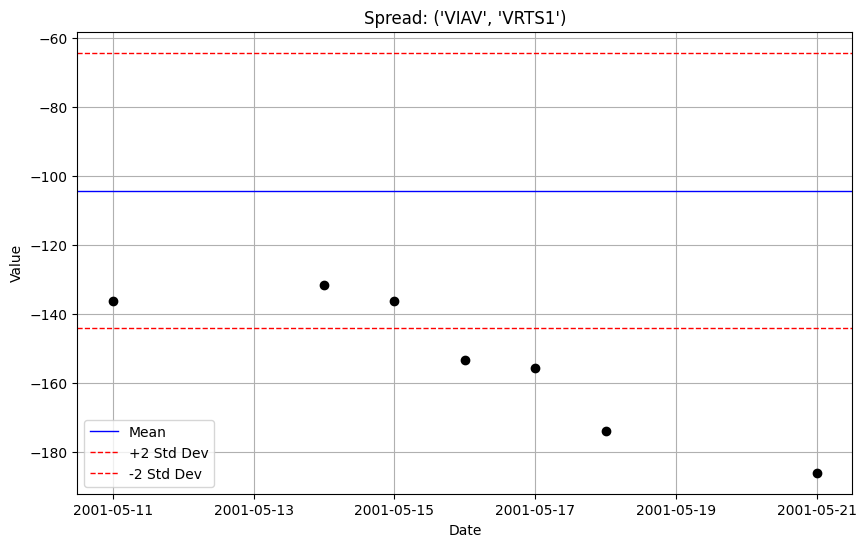

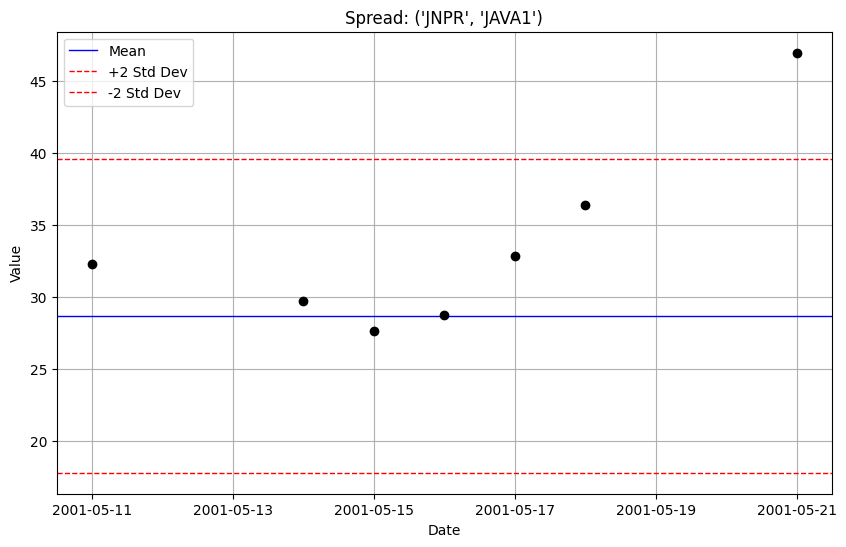

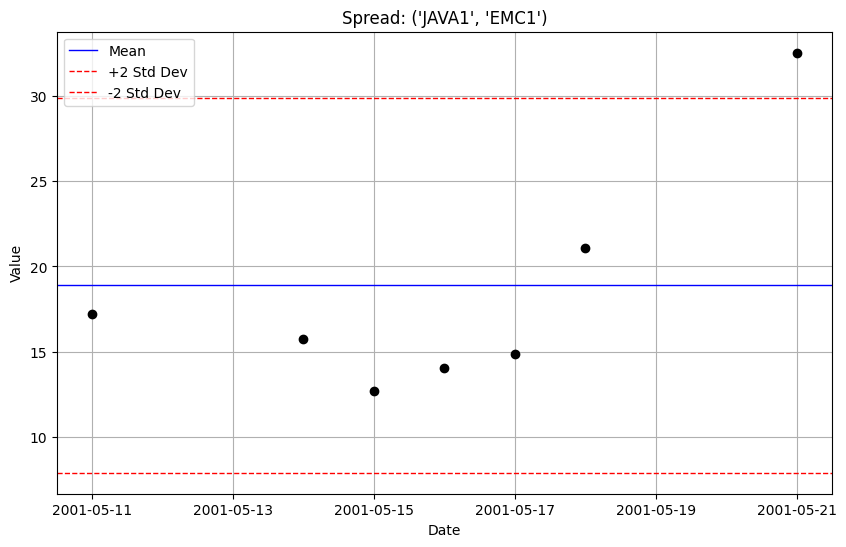

Pairs found: [('CIEN', 'CSCO')]
---------------------------- WEEKS RUNNING 37 -------------------------------------


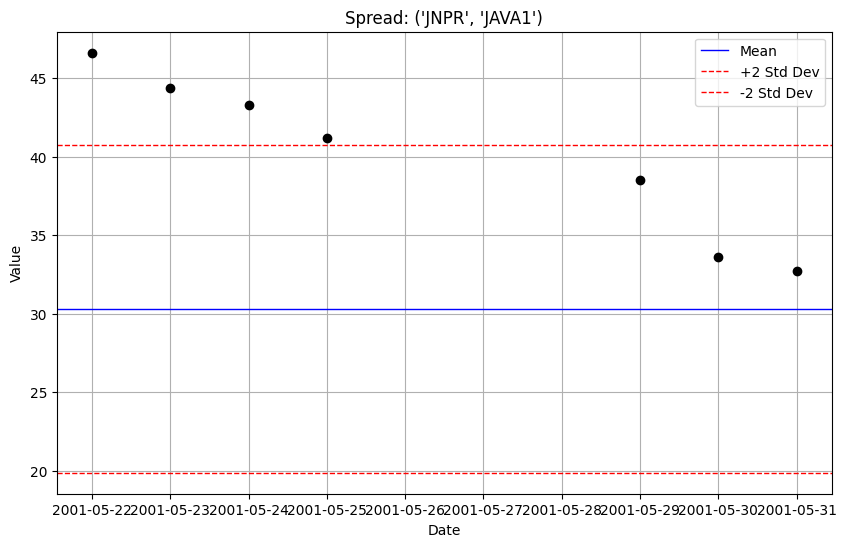

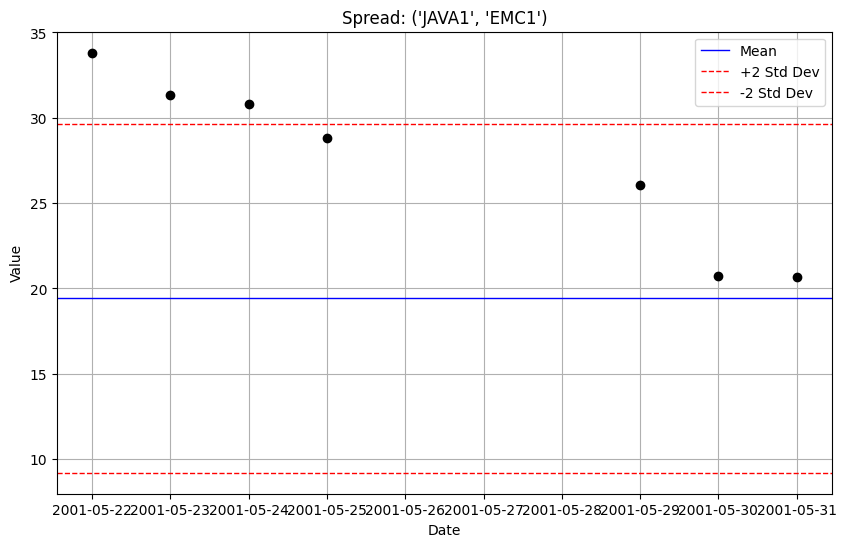

Pairs found: [('SCMR', 'LVLT'), ('SCMR', 'INTC'), ('SCMR', 'ORCL'), ('LVLT', 'ORCL'), ('INTC', 'ORCL')]
---------------------------- WEEKS RUNNING 38 -------------------------------------


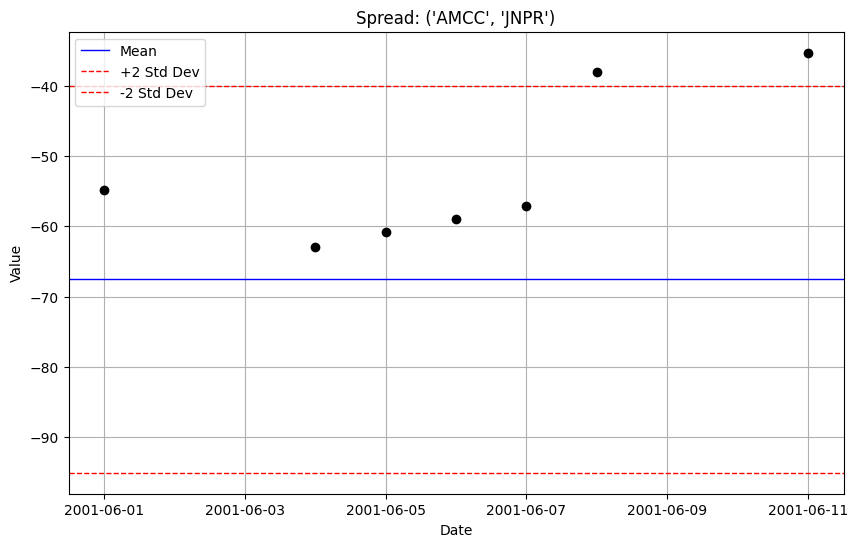

Pairs found: [('BRCD', 'VRTS1')]
---------------------------- WEEKS RUNNING 39 -------------------------------------


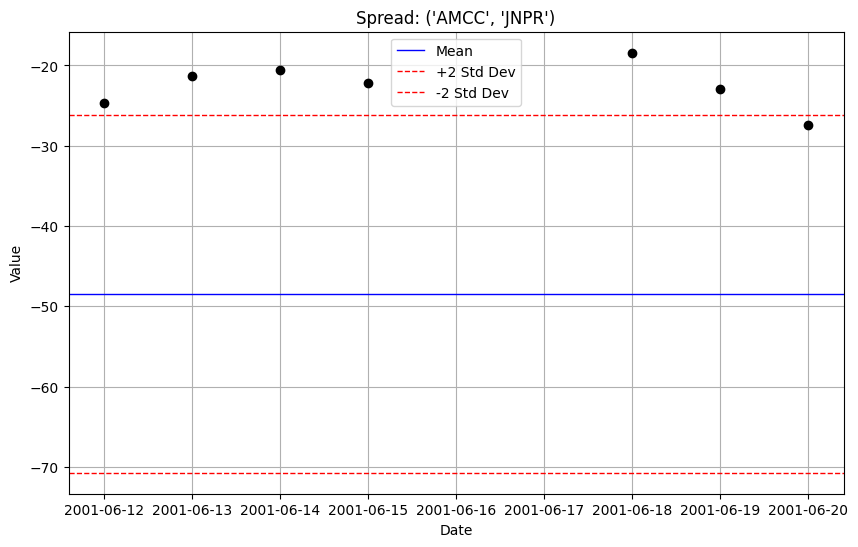

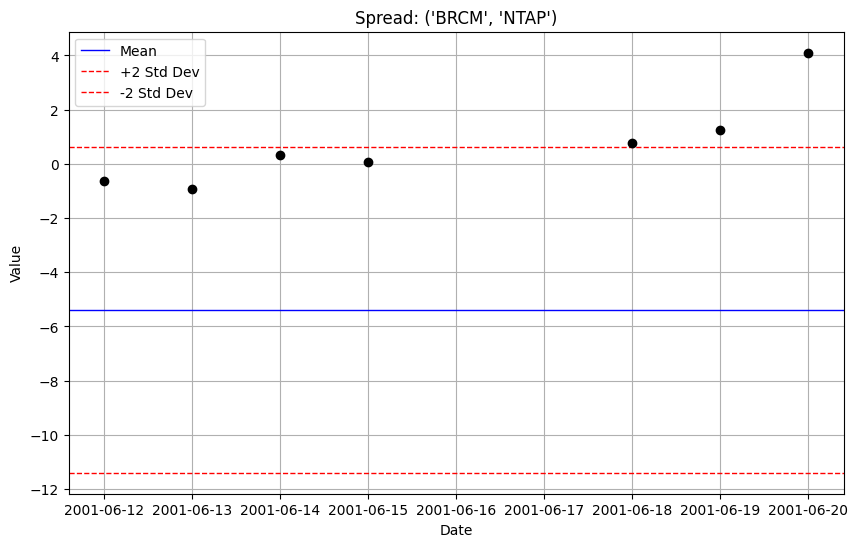

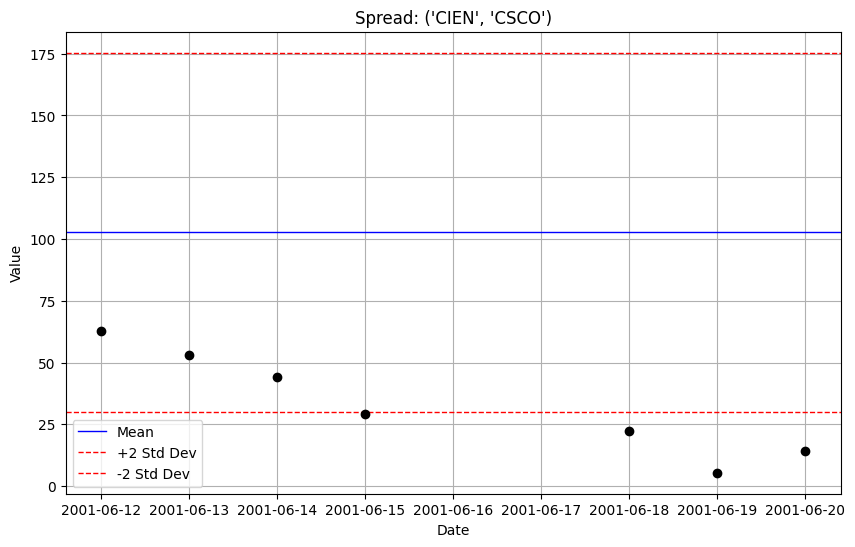

Pairs found: []
---------------------------- WEEKS RUNNING 40 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 41 -------------------------------------


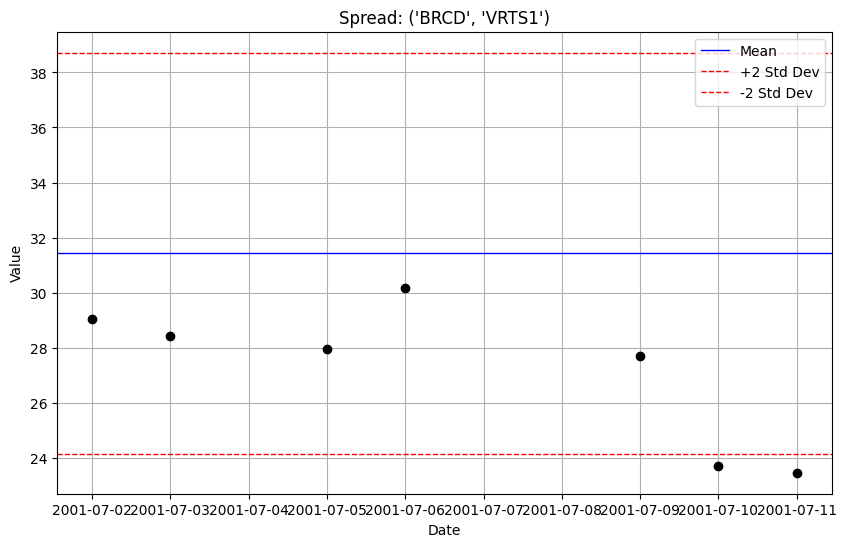

Pairs found: []
---------------------------- WEEKS RUNNING 42 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 43 -------------------------------------
Pairs found: [('PMCS', 'JAVA1')]
---------------------------- WEEKS RUNNING 44 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 45 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 46 -------------------------------------


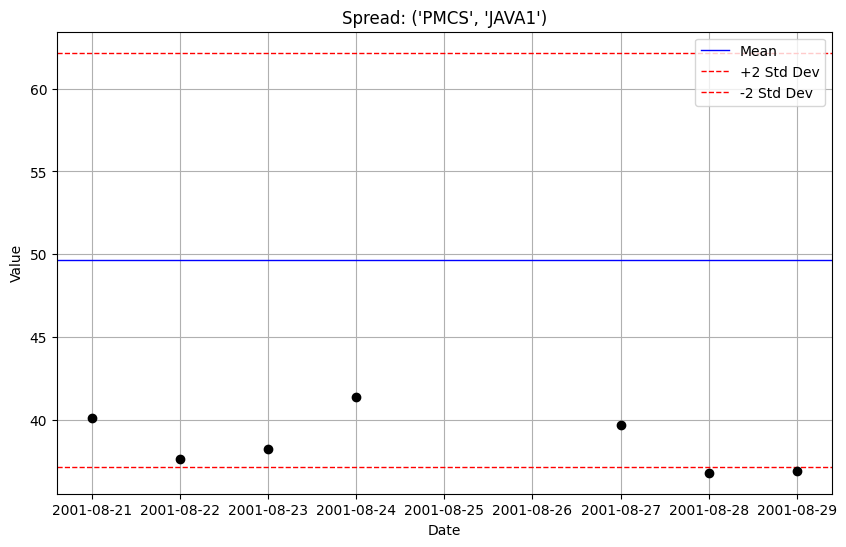

Pairs found: []
---------------------------- WEEKS RUNNING 47 -------------------------------------
Pairs found: [('IBM', 'AMAT')]
---------------------------- WEEKS RUNNING 48 -------------------------------------


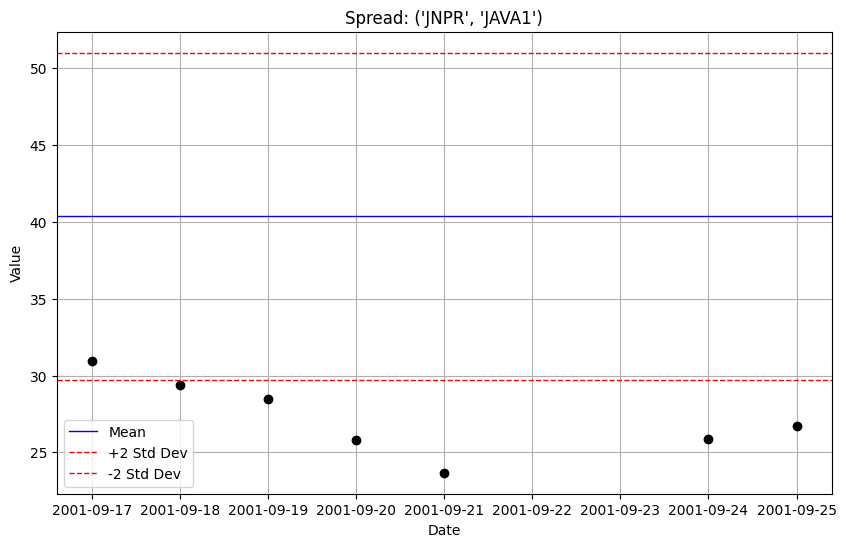

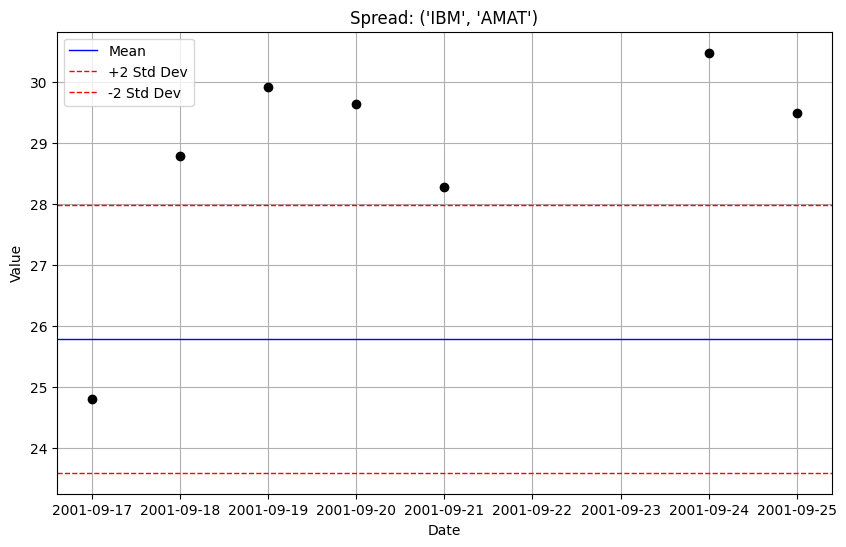

Pairs found: []
---------------------------- WEEKS RUNNING 49 -------------------------------------


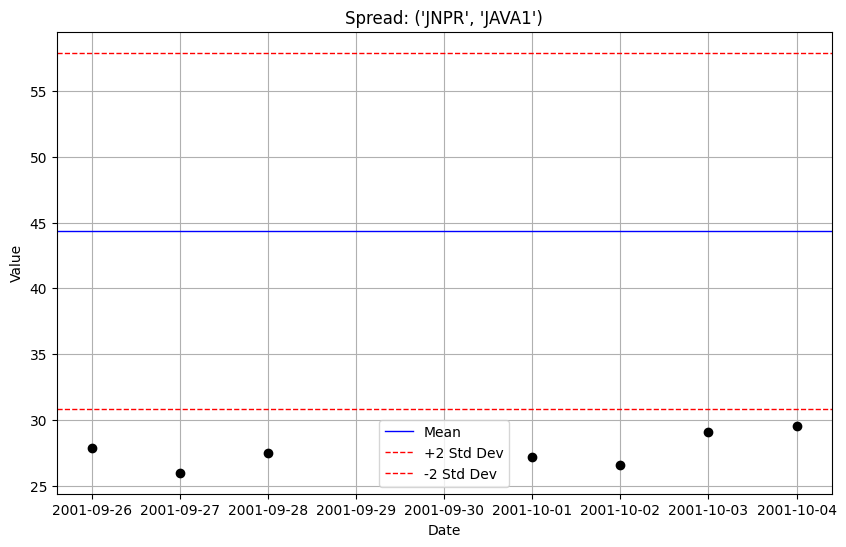

Pairs found: [('CSCO', 'JAVA1')]
---------------------------- WEEKS RUNNING 50 -------------------------------------
Pairs found: [('SCMR', 'IBM')]
---------------------------- WEEKS RUNNING 51 -------------------------------------


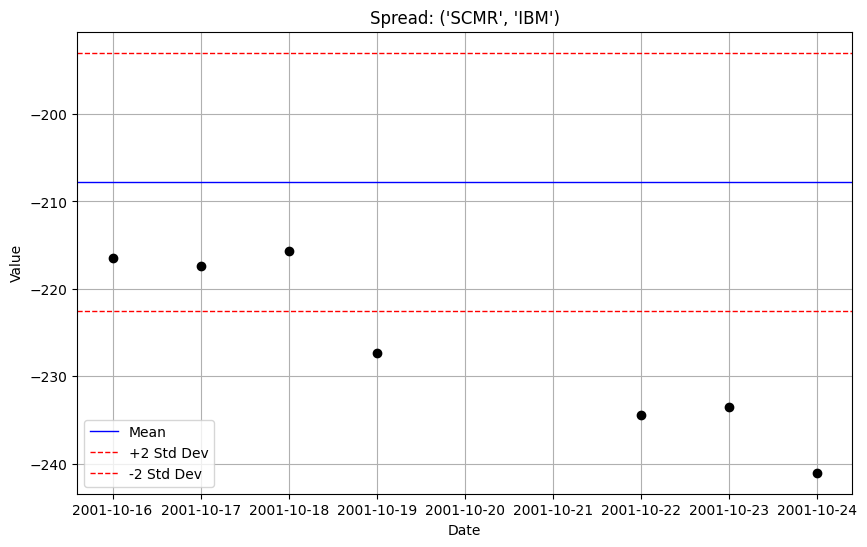

Pairs found: [('BRCM', 'INTC')]
---------------------------- WEEKS RUNNING 52 -------------------------------------


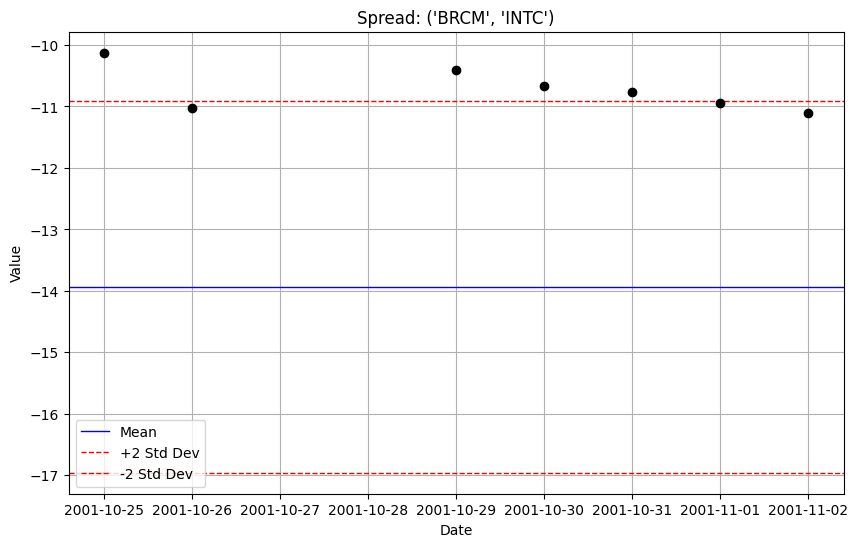

Pairs found: []
---------------------------- WEEKS RUNNING 53 -------------------------------------
Pairs found: [('DELL1', 'JNPR')]
---------------------------- WEEKS RUNNING 54 -------------------------------------
Pairs found: [('INTC', 'VRTS1'), ('VRTS1', 'DELL1')]
---------------------------- WEEKS RUNNING 55 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 56 -------------------------------------


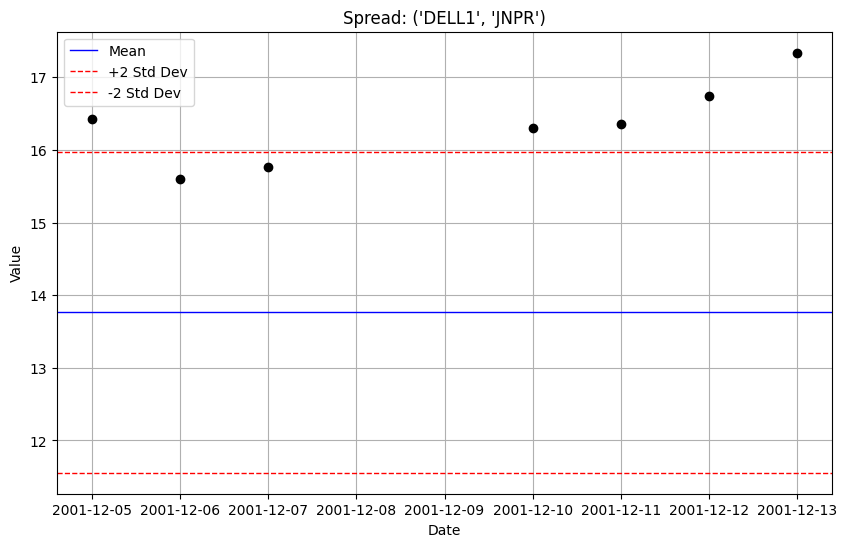

Pairs found: []
---------------------------- WEEKS RUNNING 57 -------------------------------------


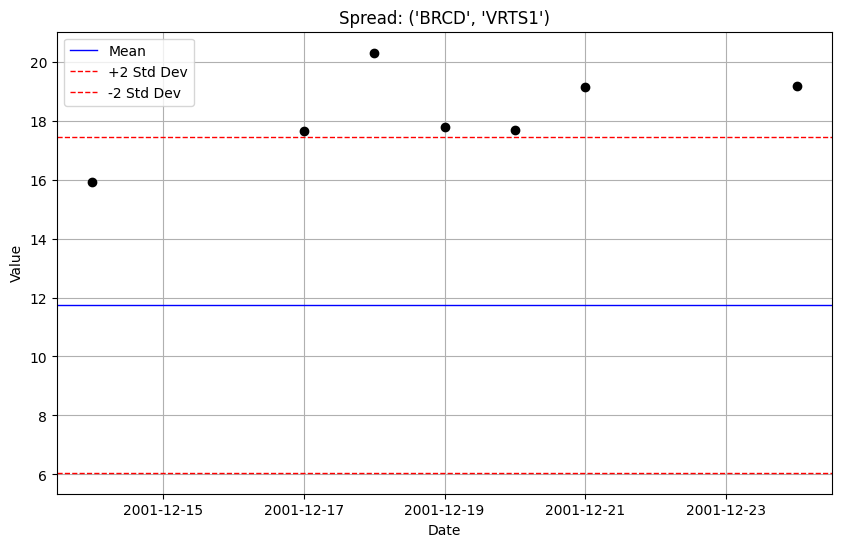

Pairs found: []
---------------------------- WEEKS RUNNING 58 -------------------------------------


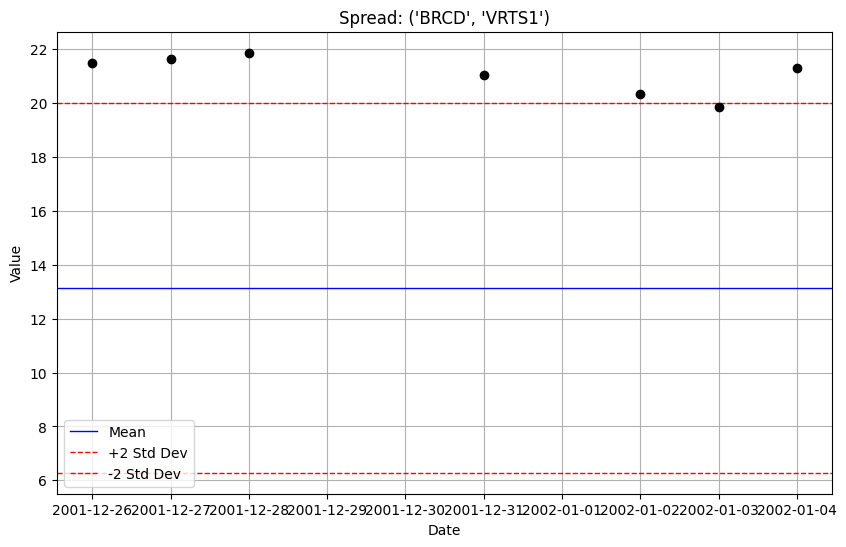

Pairs found: [('CSCO', 'BRCM')]
---------------------------- WEEKS RUNNING 59 -------------------------------------
Pairs found: [('INTC', 'YHOO'), ('AMAT', 'DELL1'), ('AMAT', 'YHOO')]
---------------------------- WEEKS RUNNING 60 -------------------------------------


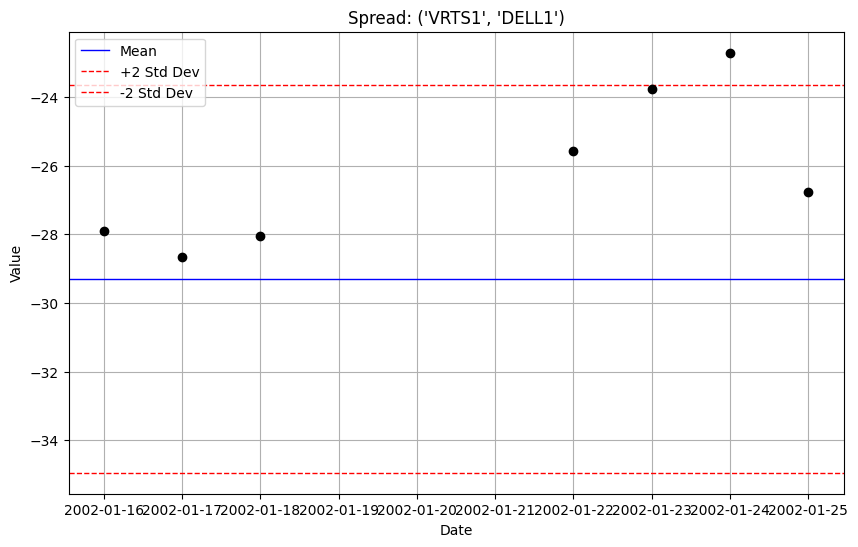

Pairs found: [('TYC', 'BCR'), ('INTC', 'VRTS1')]
---------------------------- WEEKS RUNNING 61 -------------------------------------


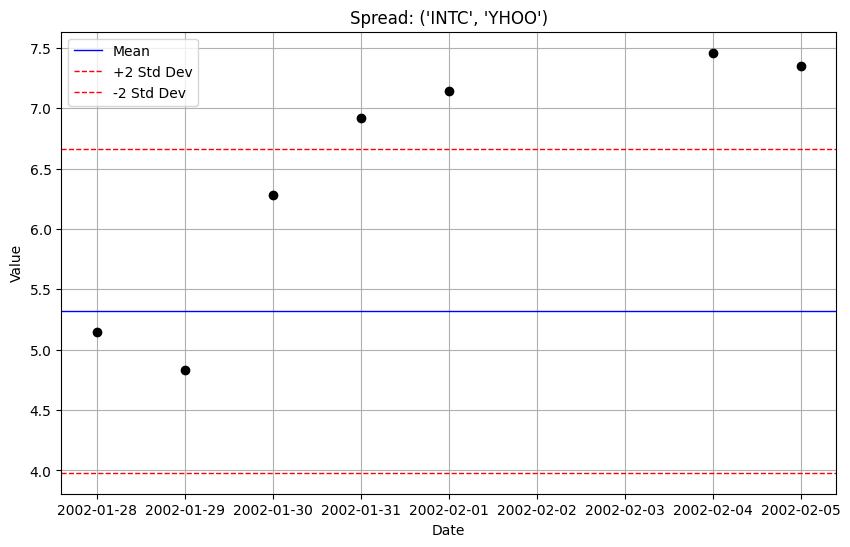

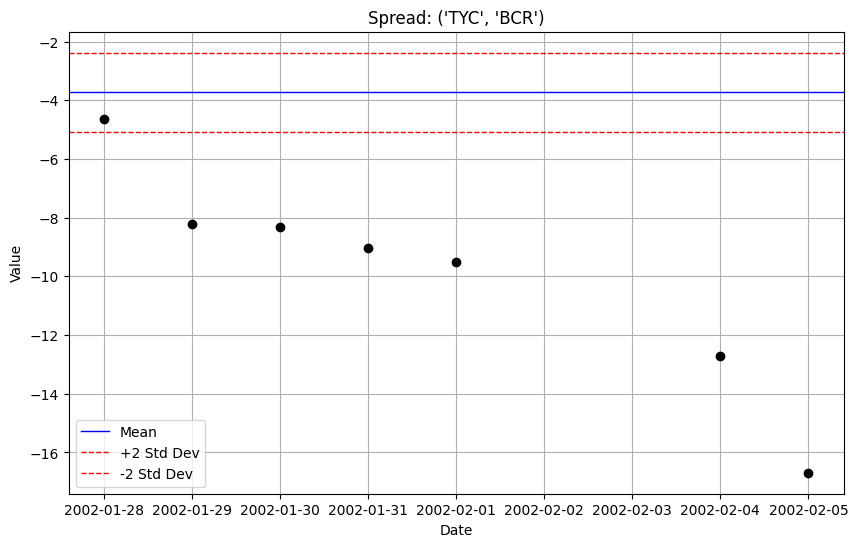

Pairs found: [('INTC', 'AMAT')]
---------------------------- WEEKS RUNNING 62 -------------------------------------


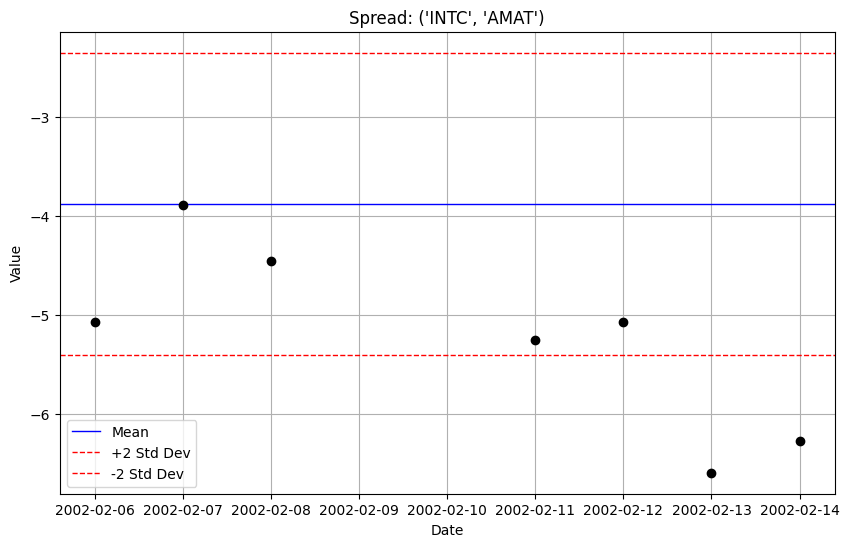

Pairs found: [('MSFT', 'IBM'), ('INTC', 'BRCD'), ('DELL1', 'BRCD')]
---------------------------- WEEKS RUNNING 63 -------------------------------------


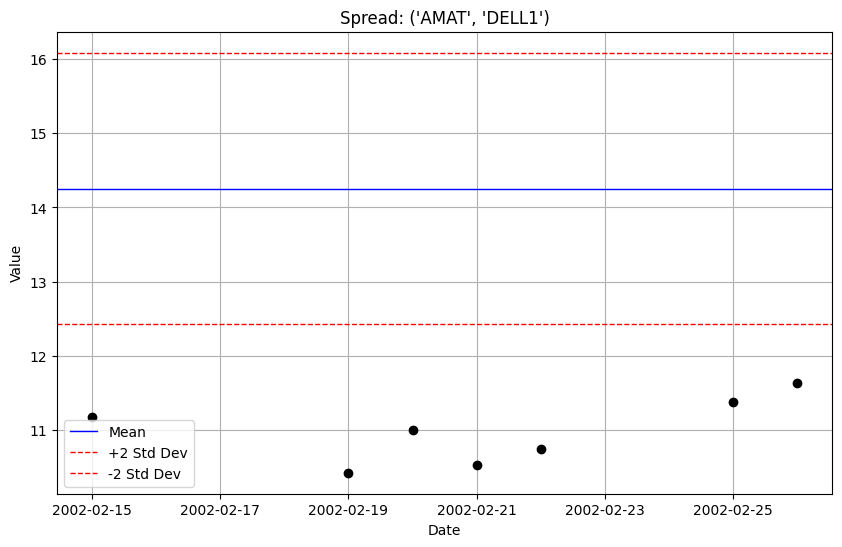

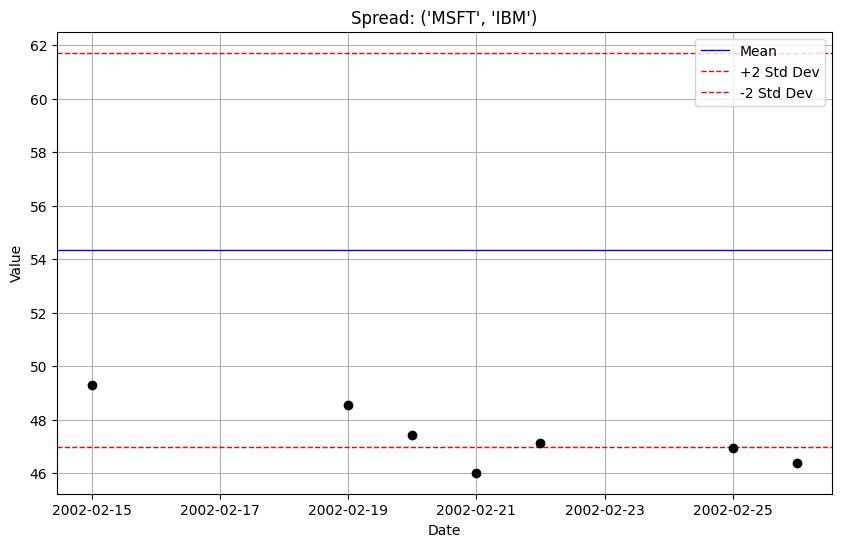

Pairs found: []
---------------------------- WEEKS RUNNING 64 -------------------------------------


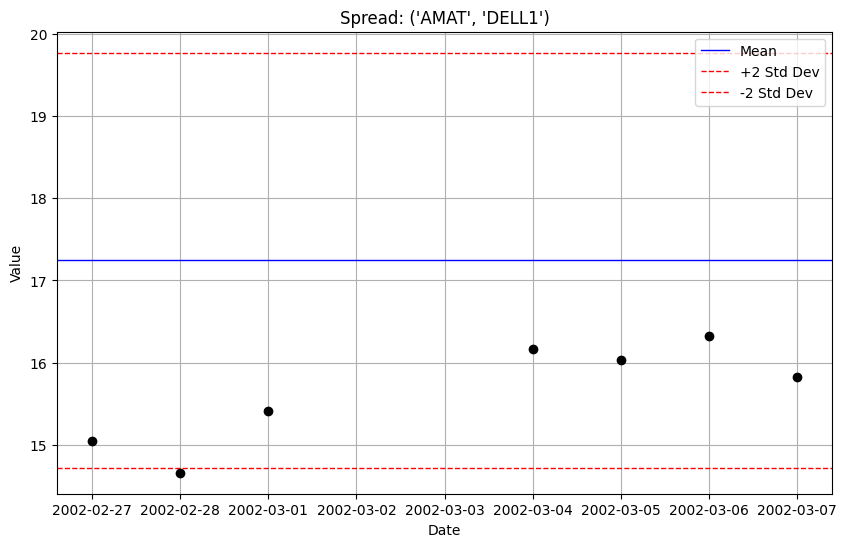

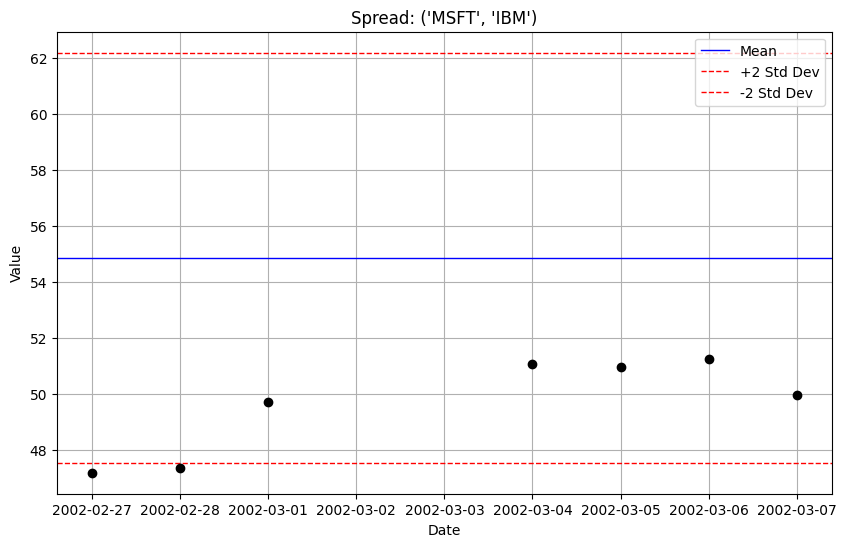

Pairs found: []
---------------------------- WEEKS RUNNING 65 -------------------------------------


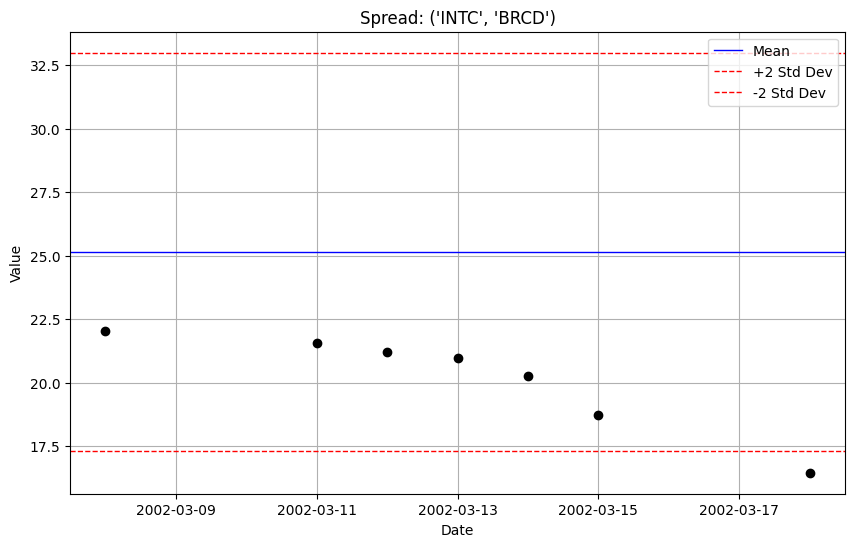

Pairs found: []
---------------------------- WEEKS RUNNING 66 -------------------------------------


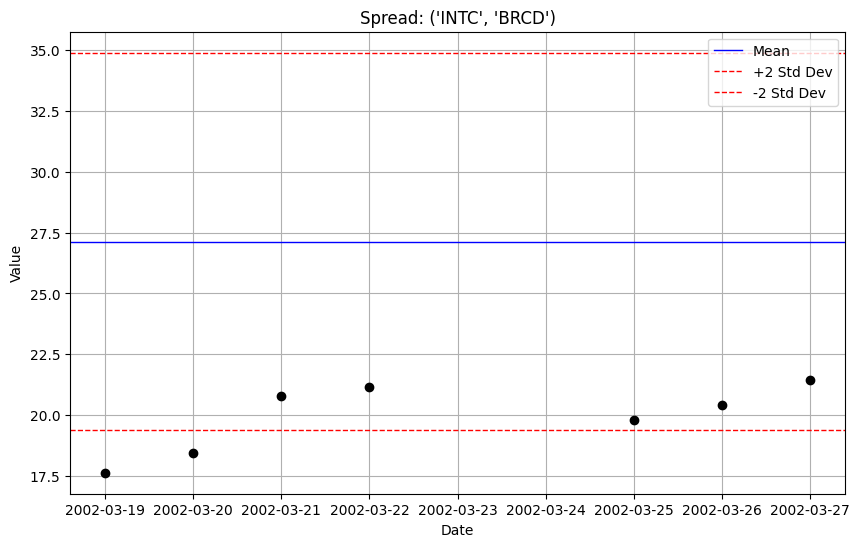

Pairs found: []
---------------------------- WEEKS RUNNING 67 -------------------------------------
Pairs found: [('NVDA', 'AMAT')]
---------------------------- WEEKS RUNNING 68 -------------------------------------
Pairs found: [('AMAT', 'ELX')]
---------------------------- WEEKS RUNNING 69 -------------------------------------


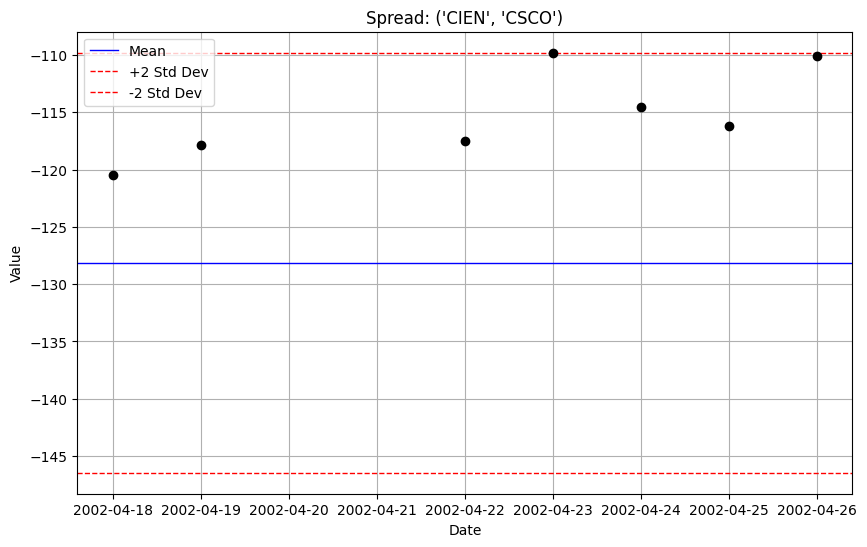

Pairs found: []
---------------------------- WEEKS RUNNING 70 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 71 -------------------------------------
Pairs found: [('DELL1', 'QLGC')]
---------------------------- WEEKS RUNNING 72 -------------------------------------
Pairs found: [('QLGC', 'DELL1')]
---------------------------- WEEKS RUNNING 73 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 74 -------------------------------------


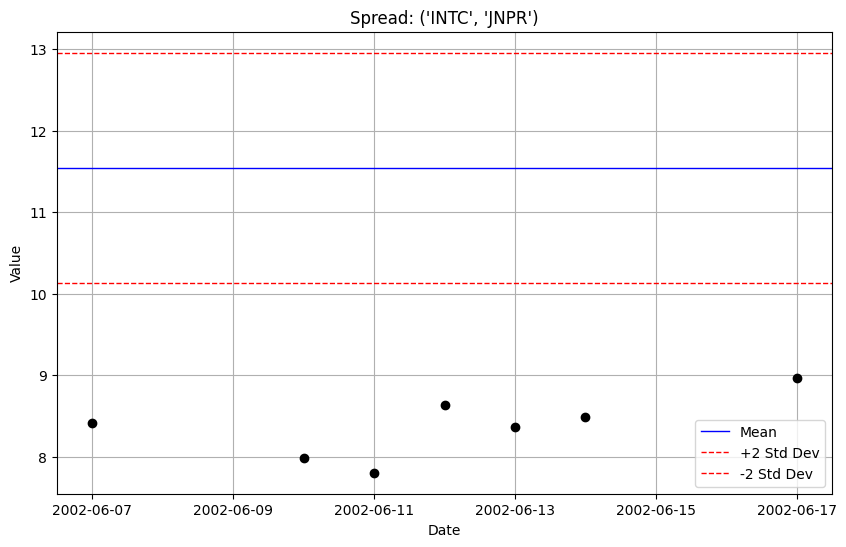

Pairs found: []
---------------------------- WEEKS RUNNING 75 -------------------------------------


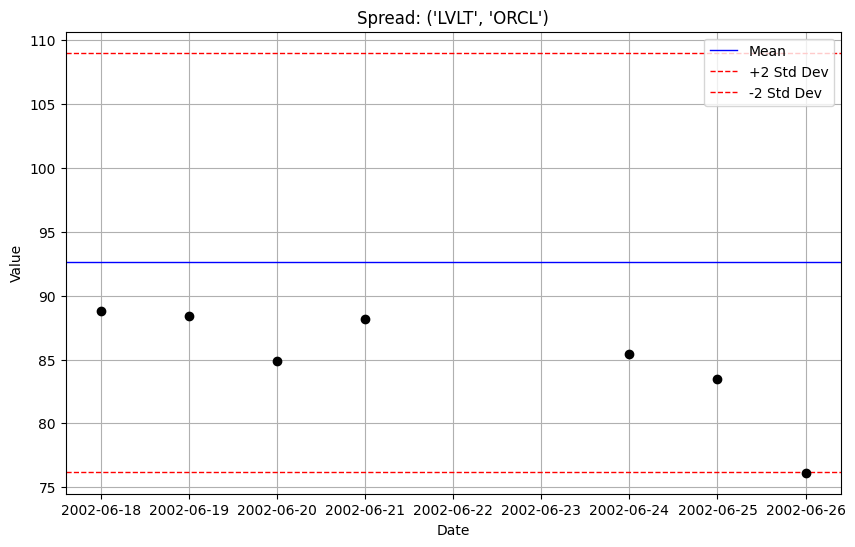

Pairs found: []
---------------------------- WEEKS RUNNING 76 -------------------------------------


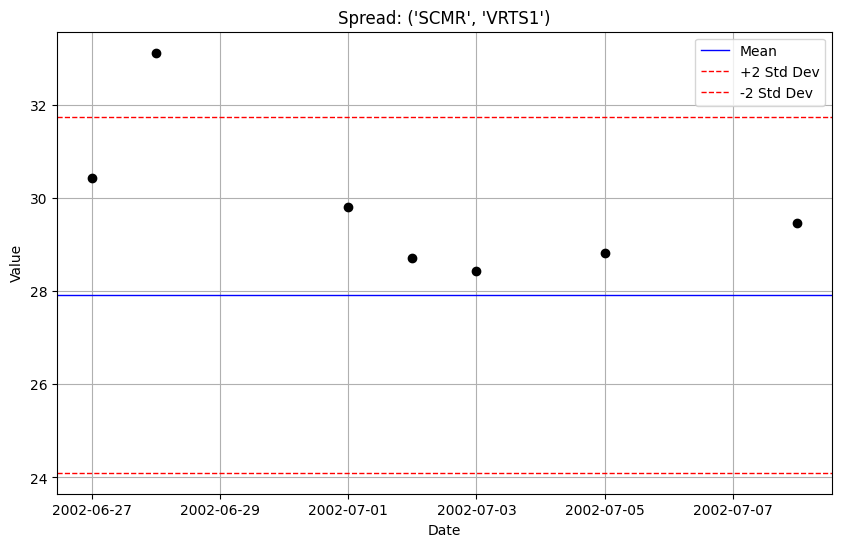

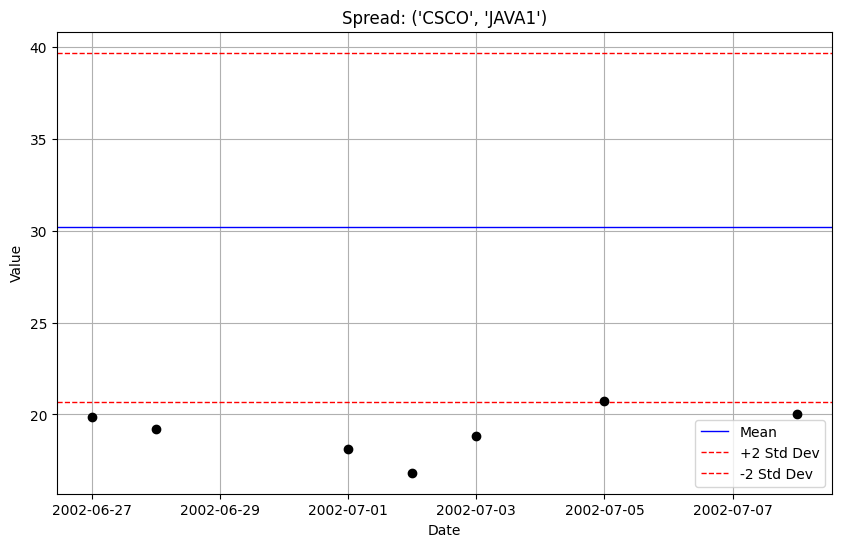

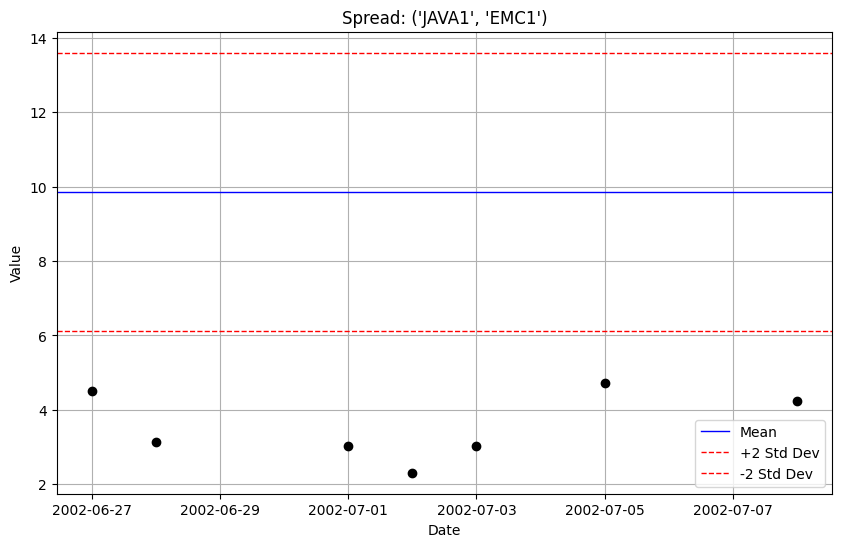

Pairs found: [('WYE', 'AMGN')]
---------------------------- WEEKS RUNNING 77 -------------------------------------


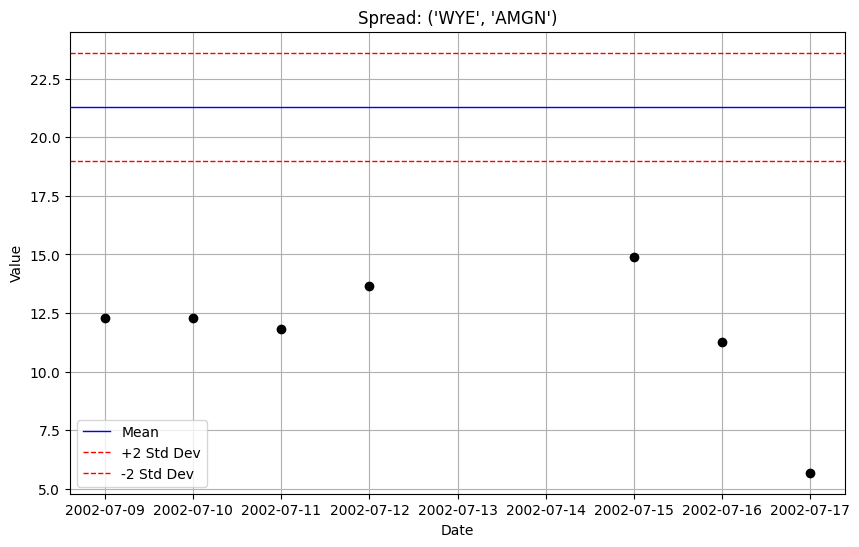

Pairs found: [('JAVA1', 'AMGN')]
---------------------------- WEEKS RUNNING 78 -------------------------------------


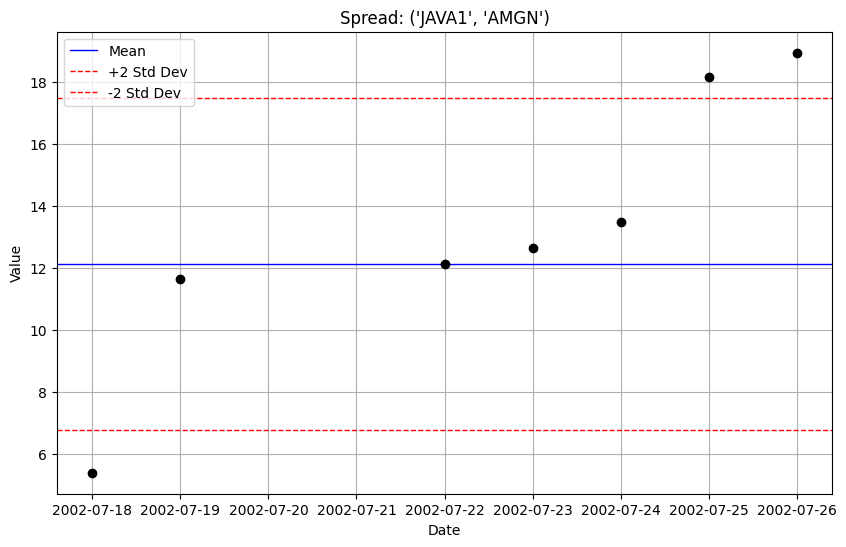

Pairs found: [('INTC', 'JNJ')]
---------------------------- WEEKS RUNNING 79 -------------------------------------


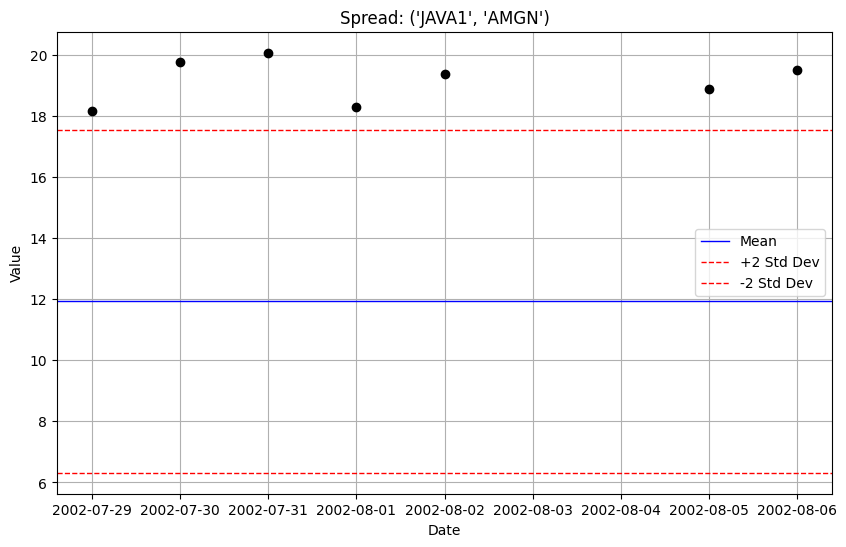

Pairs found: []
---------------------------- WEEKS RUNNING 80 -------------------------------------
Pairs found: [('INTC', 'IBM')]
---------------------------- WEEKS RUNNING 81 -------------------------------------


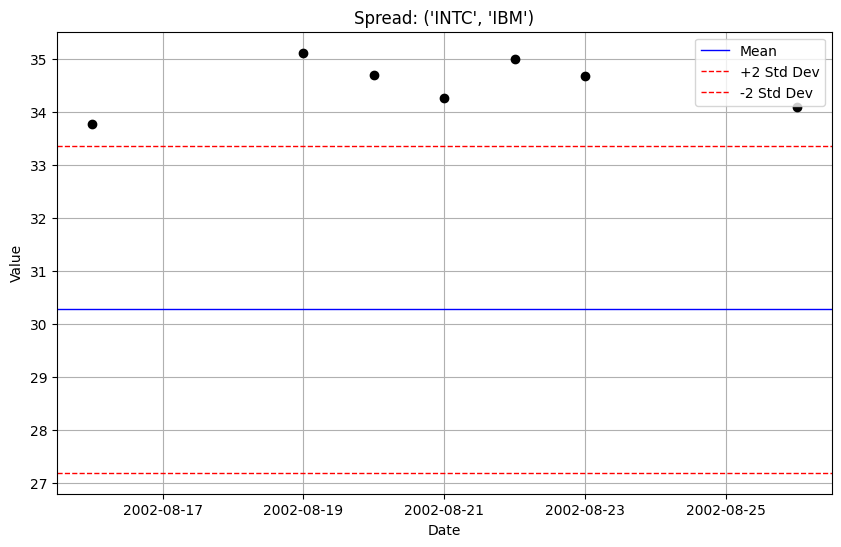

Pairs found: []
---------------------------- WEEKS RUNNING 82 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 83 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 84 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 85 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 86 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 87 -------------------------------------


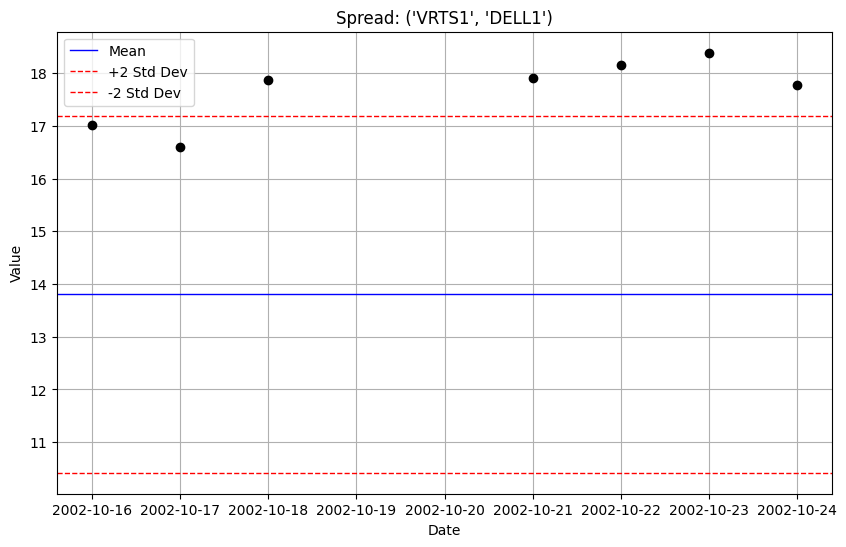

Pairs found: [('INTC', 'QLGC')]
---------------------------- WEEKS RUNNING 88 -------------------------------------


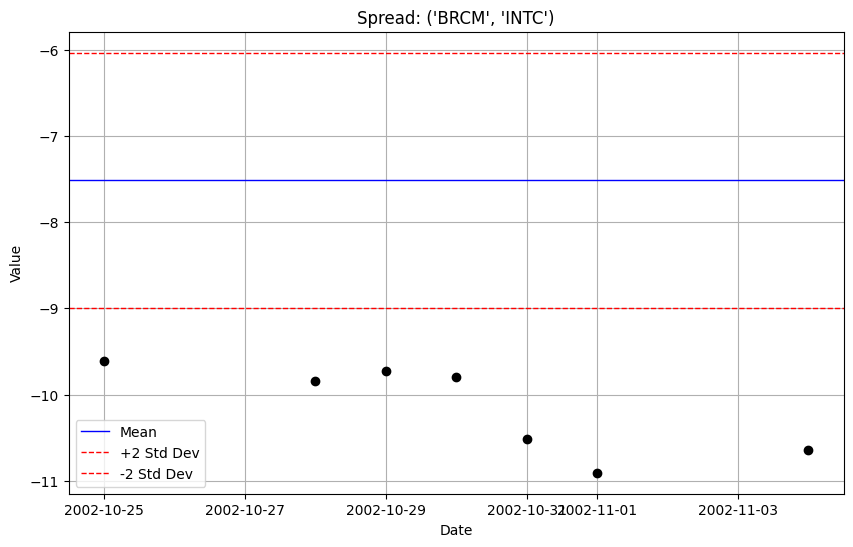

Pairs found: []
---------------------------- WEEKS RUNNING 89 -------------------------------------


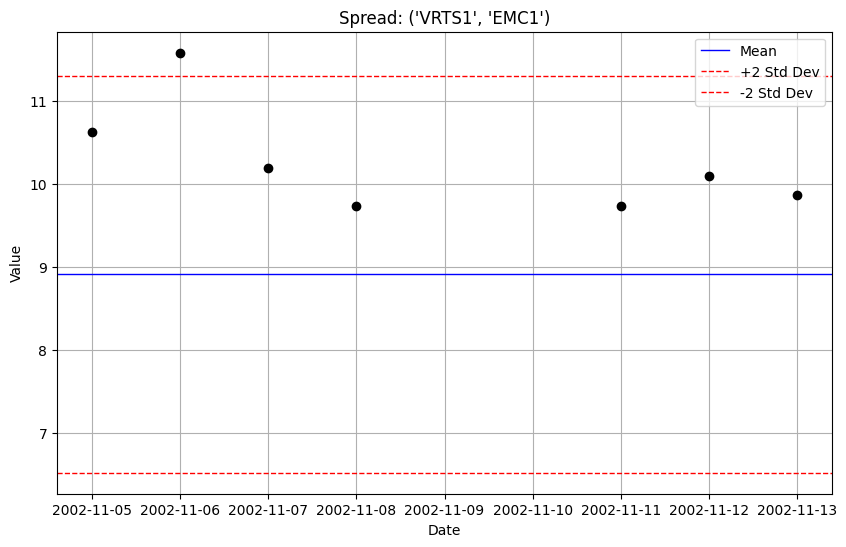

Pairs found: []
---------------------------- WEEKS RUNNING 90 -------------------------------------


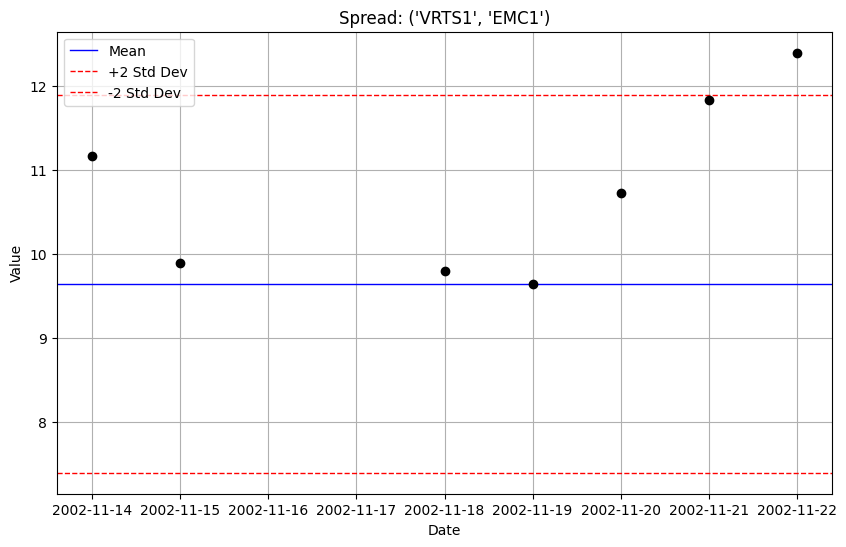

Pairs found: []
---------------------------- WEEKS RUNNING 91 -------------------------------------


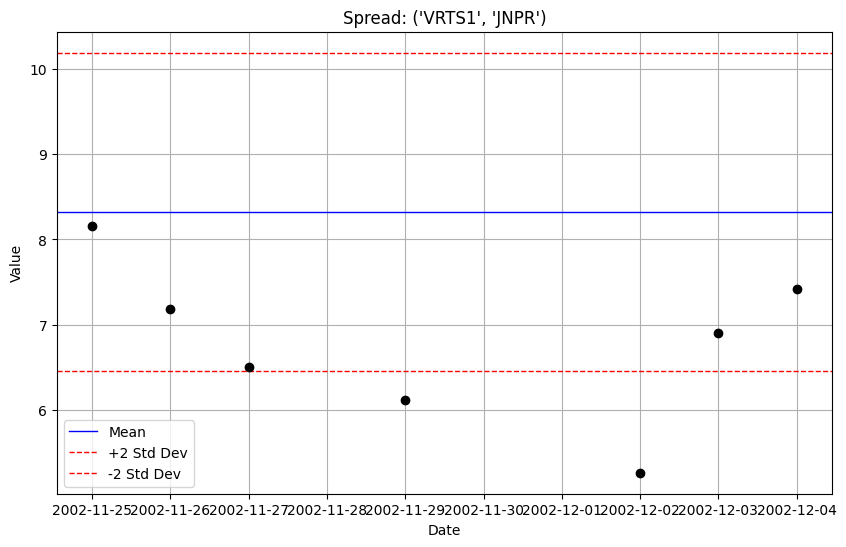

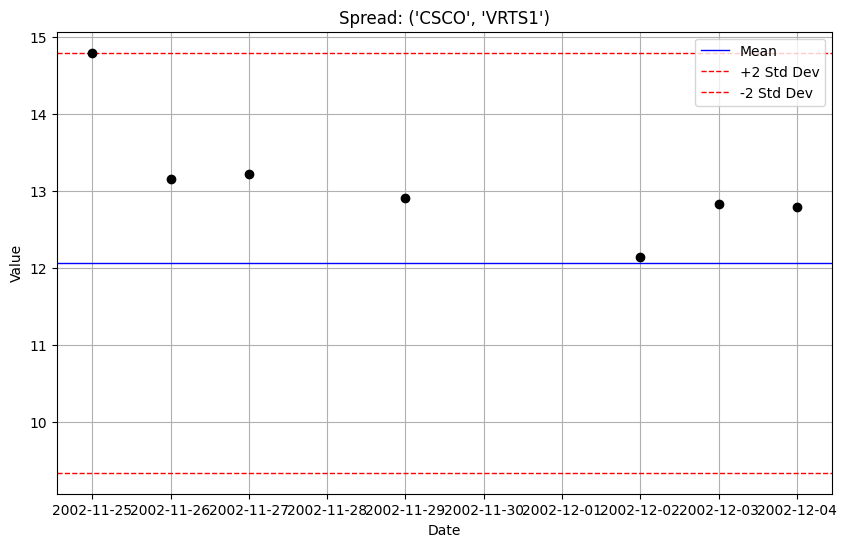

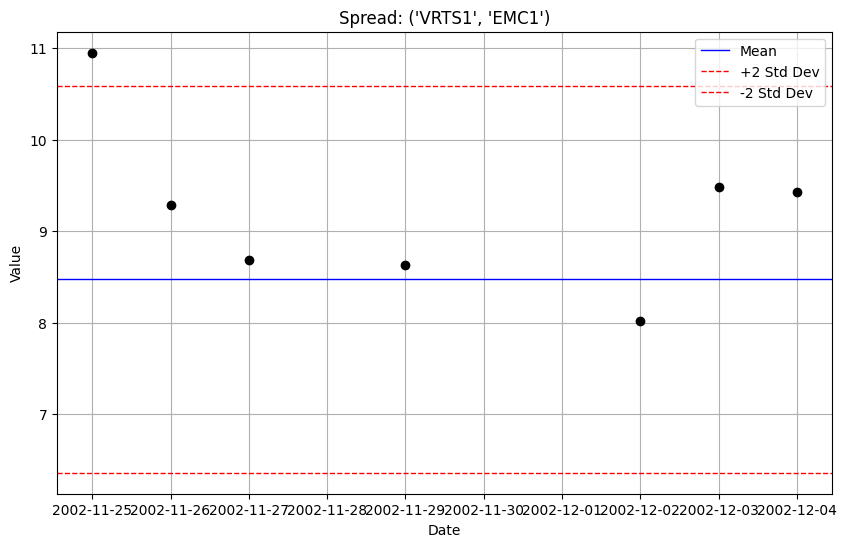

Pairs found: []
---------------------------- WEEKS RUNNING 92 -------------------------------------
Pairs found: [('MSFT', 'NVLS1')]
---------------------------- WEEKS RUNNING 93 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 94 -------------------------------------


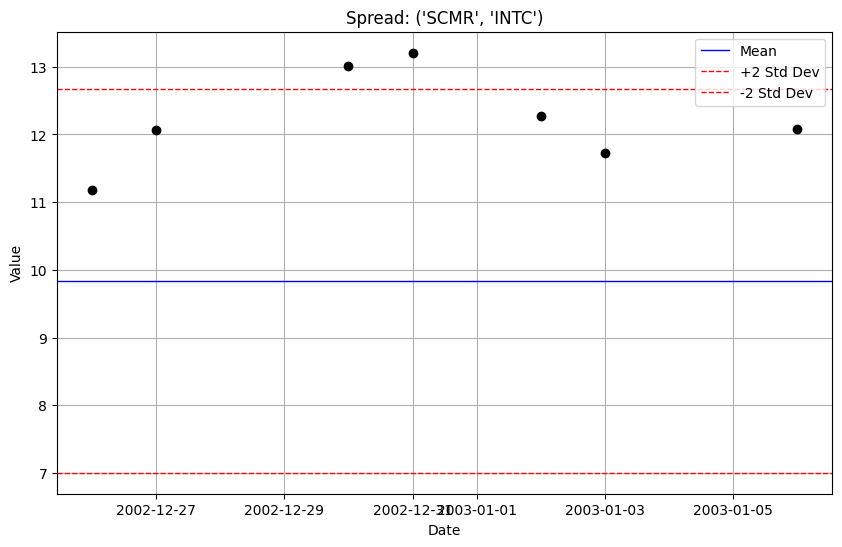

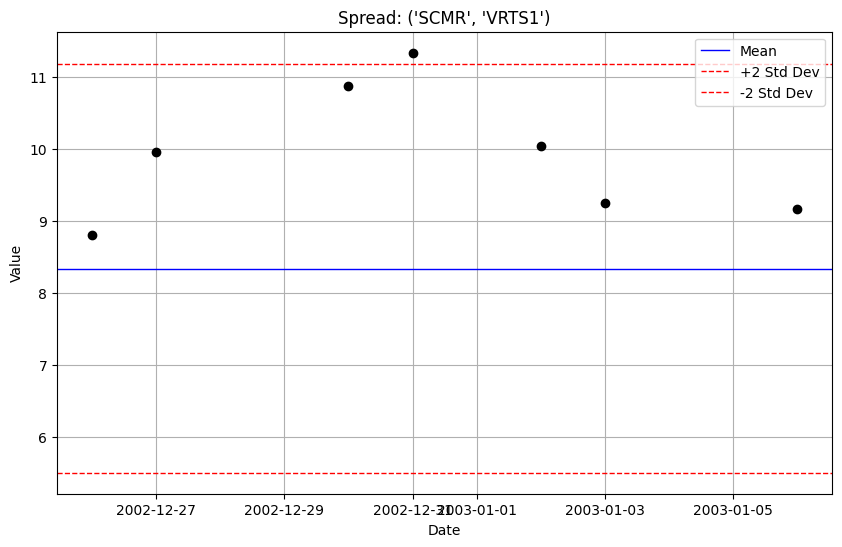

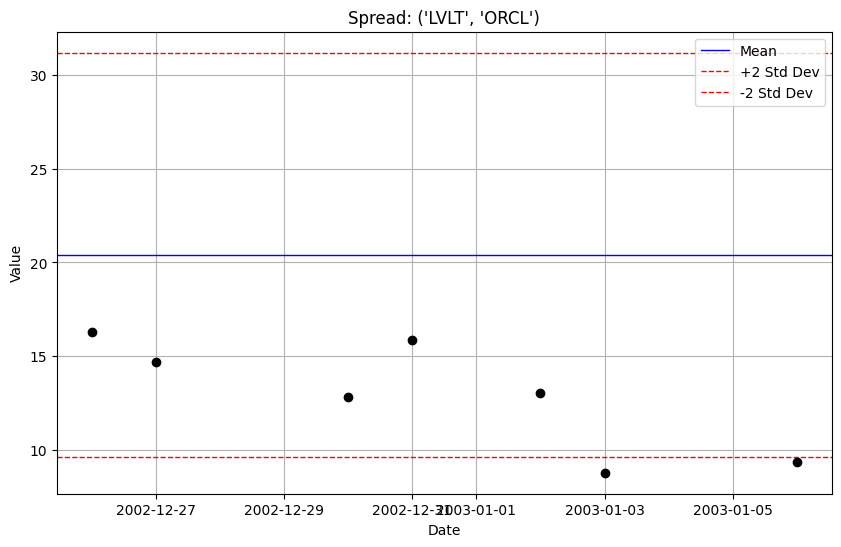

Pairs found: []
---------------------------- WEEKS RUNNING 95 -------------------------------------


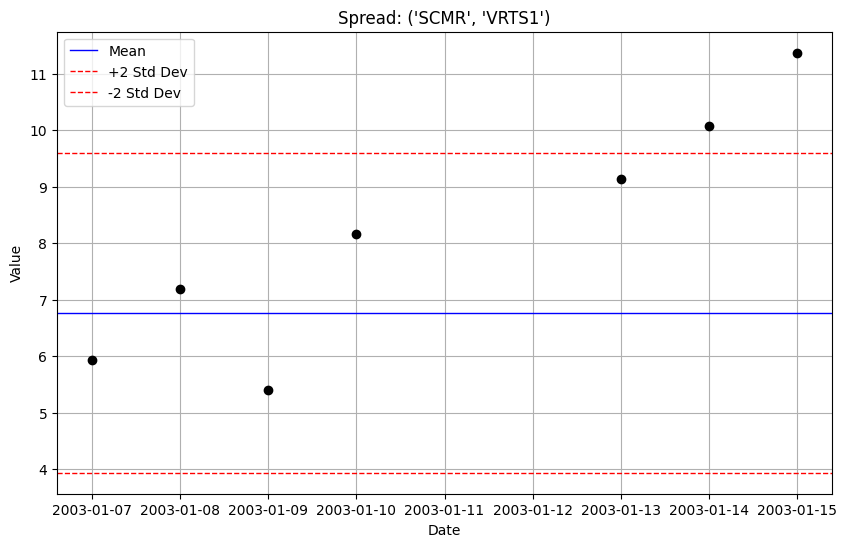

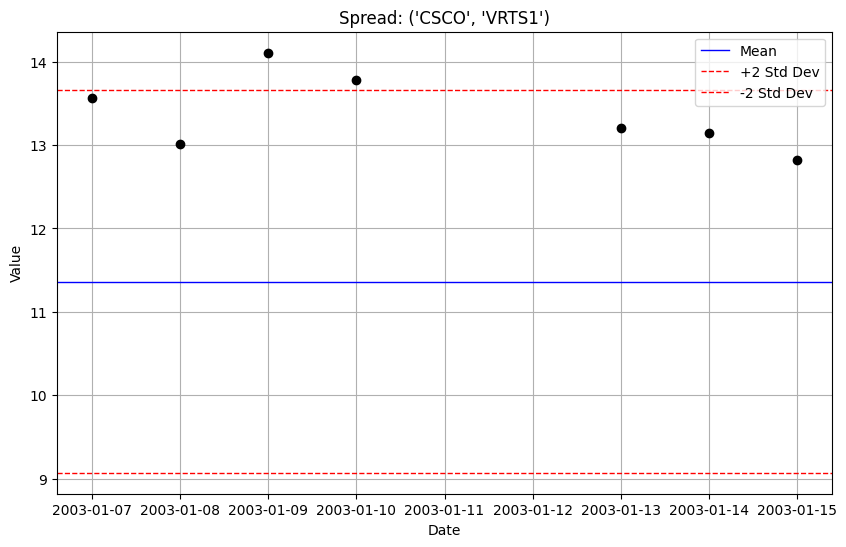

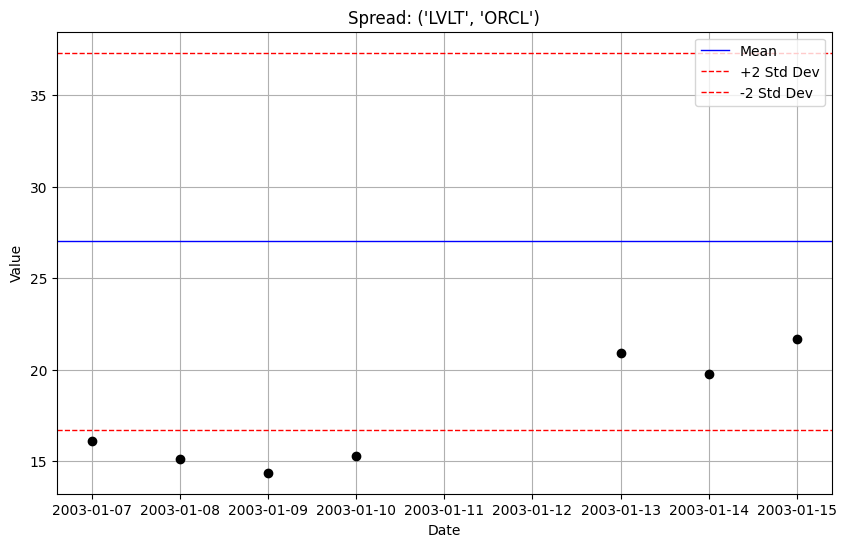

Pairs found: []
---------------------------- WEEKS RUNNING 96 -------------------------------------


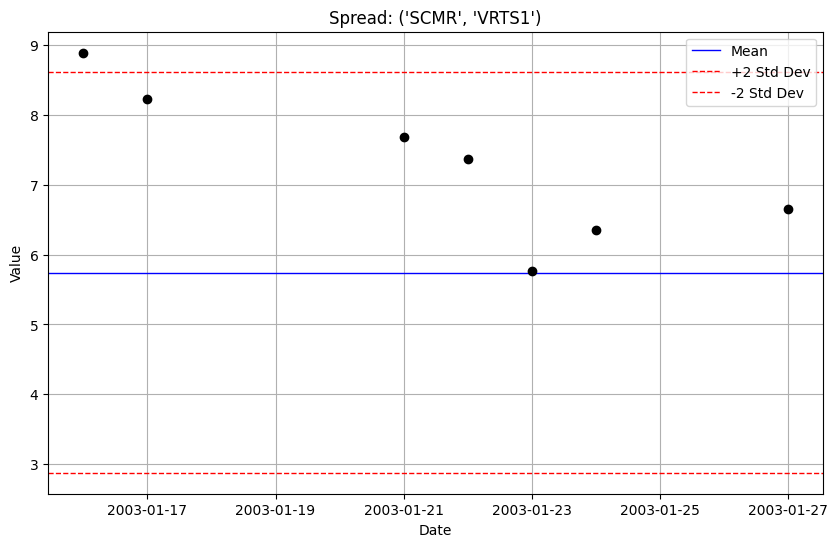

Pairs found: []
---------------------------- WEEKS RUNNING 97 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 98 -------------------------------------
Pairs found: [('DELL1', 'AMGN')]
---------------------------- WEEKS RUNNING 99 -------------------------------------


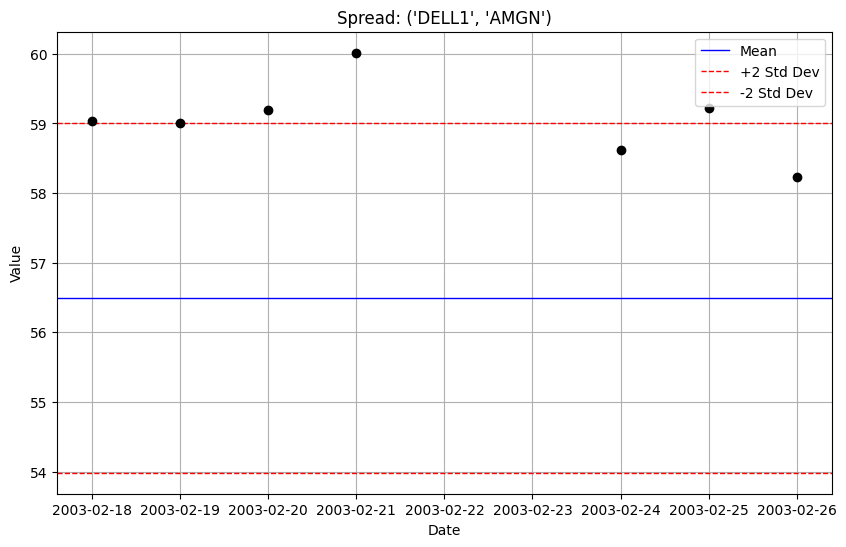

Pairs found: [('DELL1', 'AMGN')]
---------------------------- WEEKS RUNNING 100 -------------------------------------


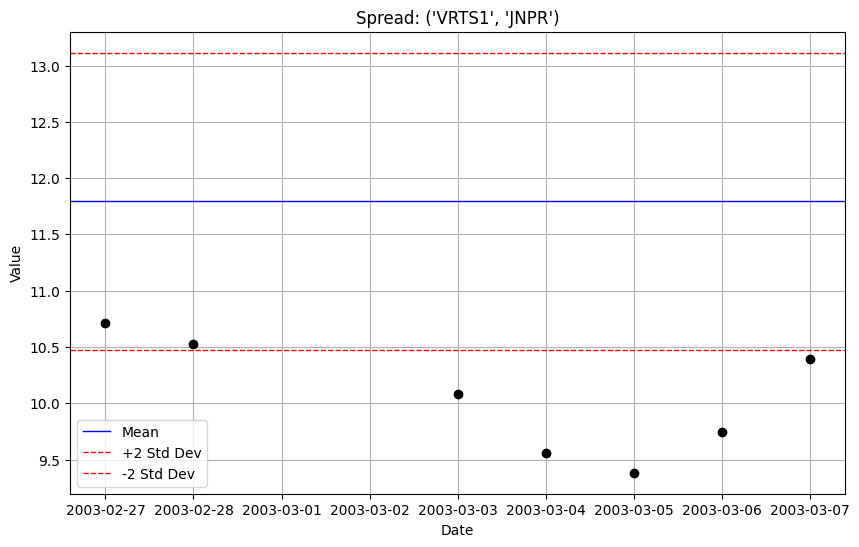

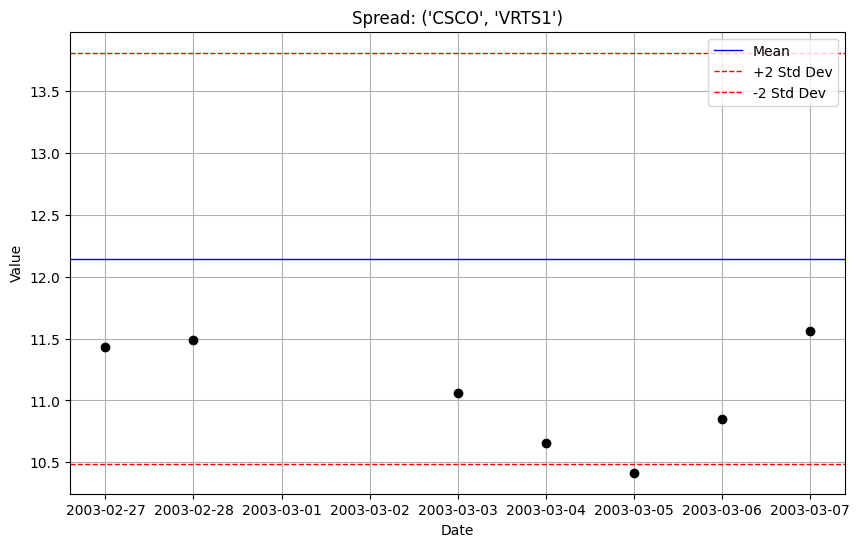

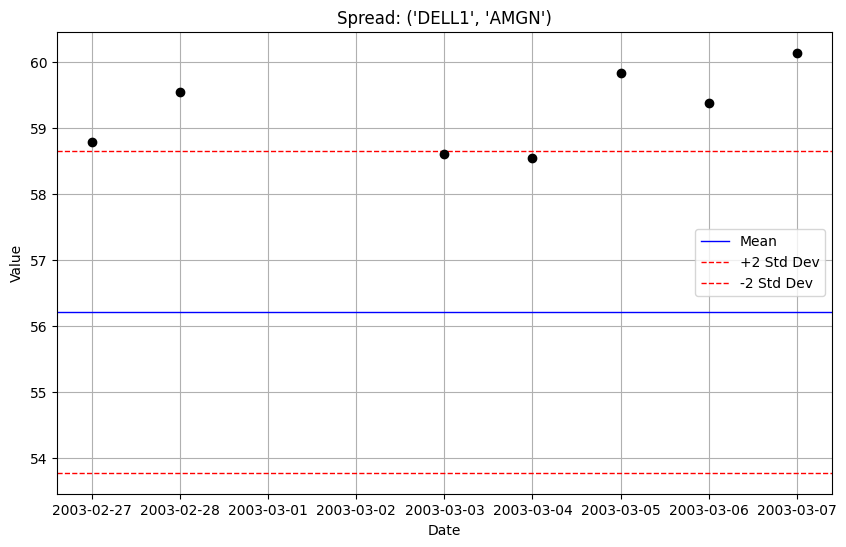

Pairs found: []
{('AMAT', 'DELL1'): [False,
                     ['2001-08-22',
                      '2002-02-05',
                      '2002-02-14',
                      '2002-02-26',
                      '2002-09-05'],
                     ['2002-01-25',
                      '2002-02-05',
                      '2002-02-14',
                      '2002-02-26',
                      '2002-09-16'],
                     [['2002-01-31', '2002-02-01', '2002-02-04', '2002-02-05'],
                      [],
                      ['2002-02-15',
                       '2002-02-19',
                       '2002-02-20',
                       '2002-02-21',
                       '2002-02-22',
                       '2002-02-25',
                       '2002-02-26'],
                      ['2002-02-28'],
                      []]],
 ('AMAT', 'ELX'): [False,
                   ['2001-11-27', '2002-05-07'],
                   ['2002-04-17', '2002-05-28'],
                   [[], []]],
 ('AMAT'

In [92]:
pair_dict = {
        # [ still_consecutive, [start_dates], [end_date] weeks_counted, [[days_to_open_trade]] ]
        ('INTC', 'ORCL') : [ True, ['2000-01-03'], [], [[]] ]
    }
# monitor_group_of_pairs(prices_with_market, pair_dict, 200)
import pprint

pprint.pprint(monitor_group_of_pairs(prices_with_market, pair_dict, 100))

# ["MGI", "MDLZ", "DWA", "ICE"]

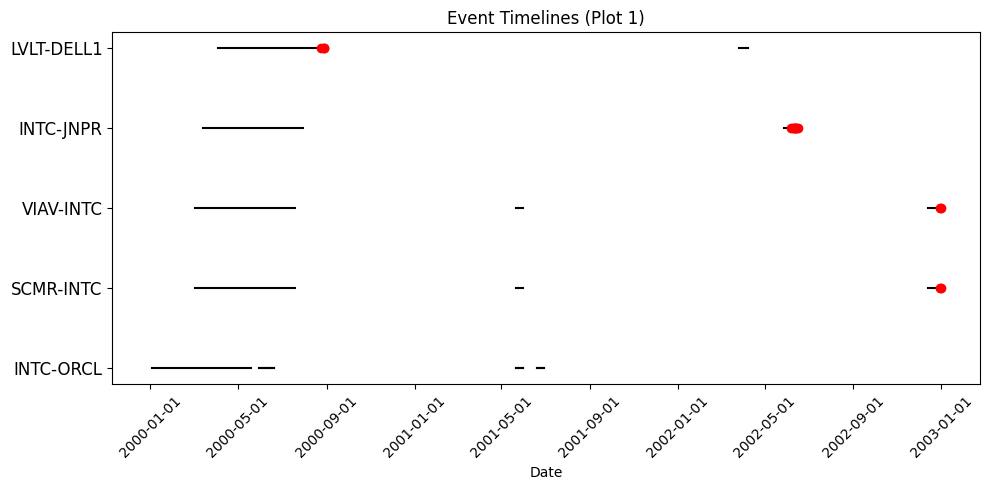

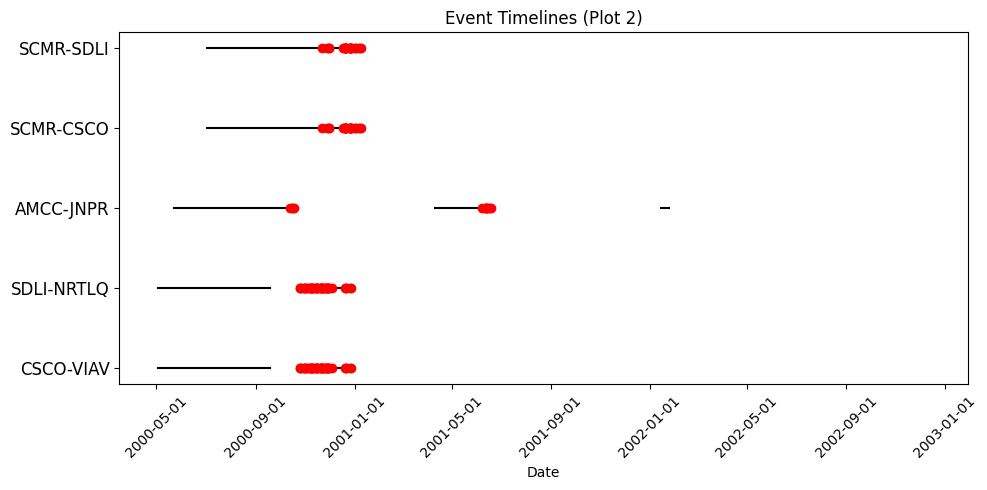

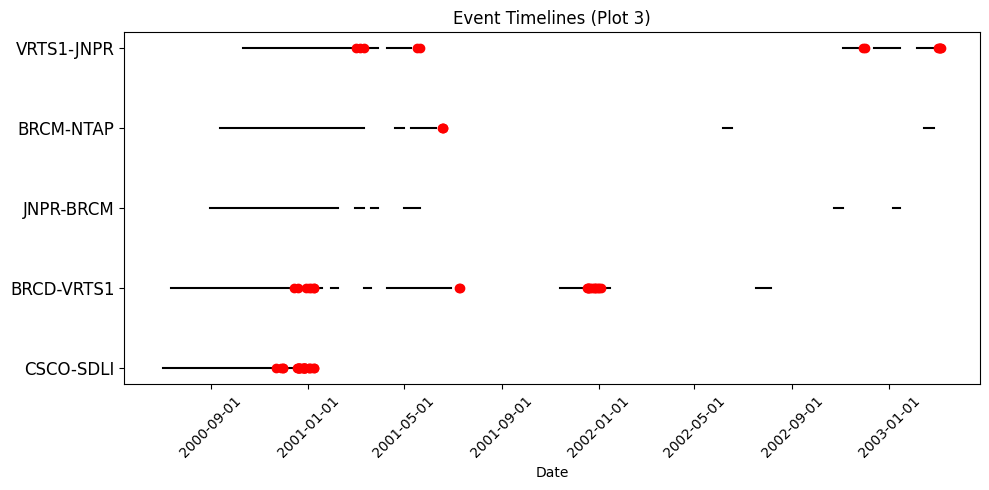

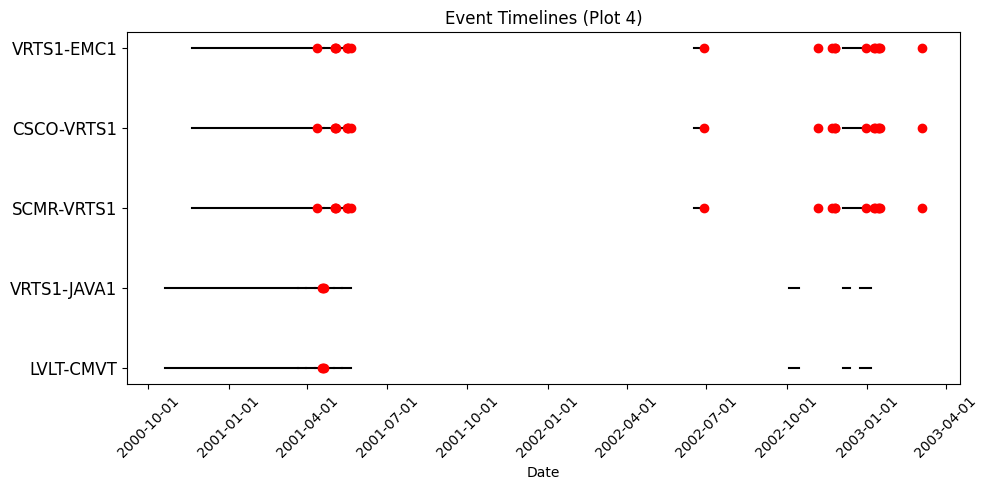

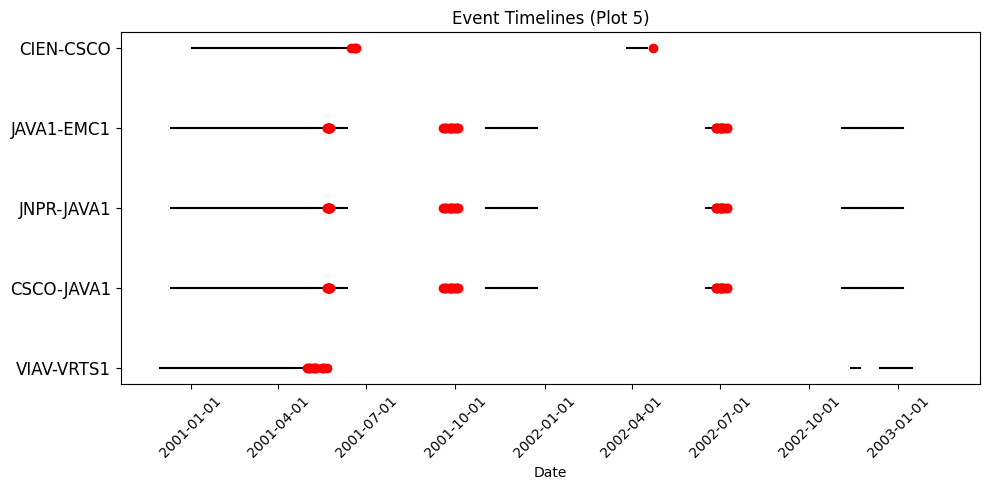

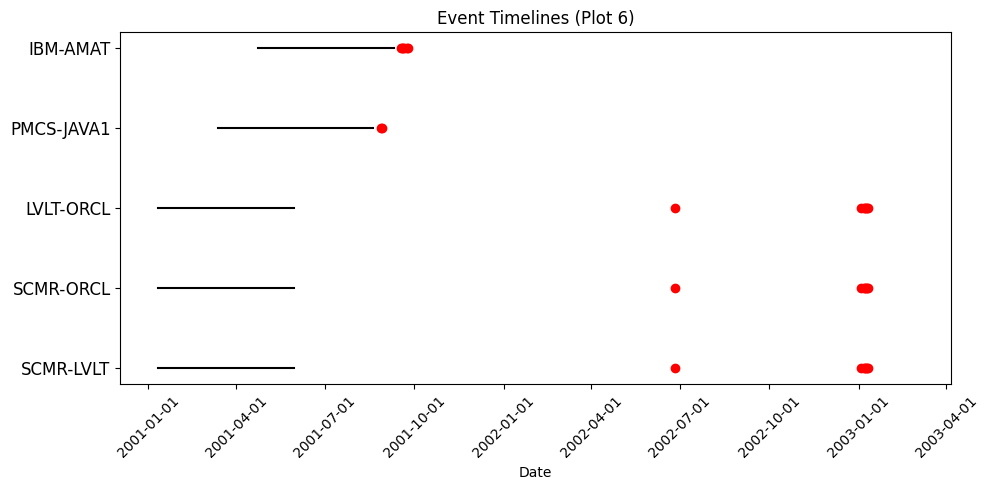

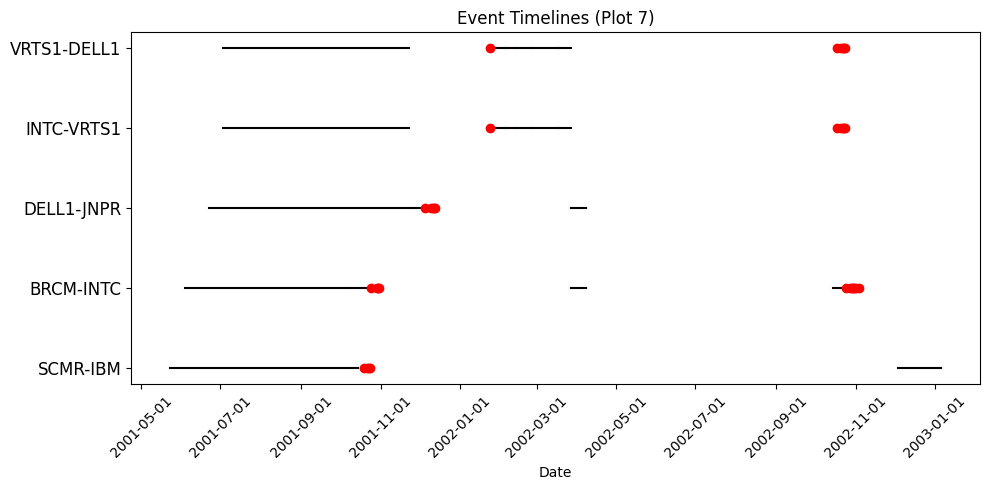

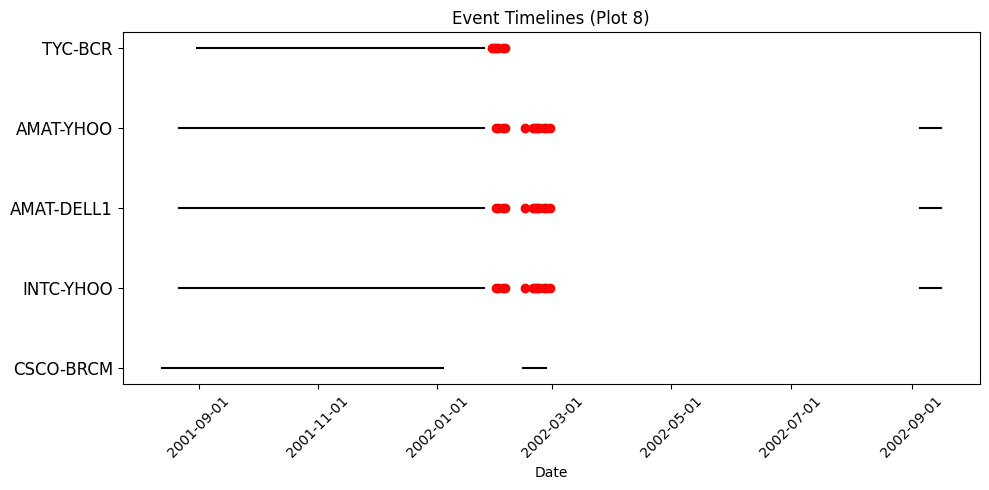

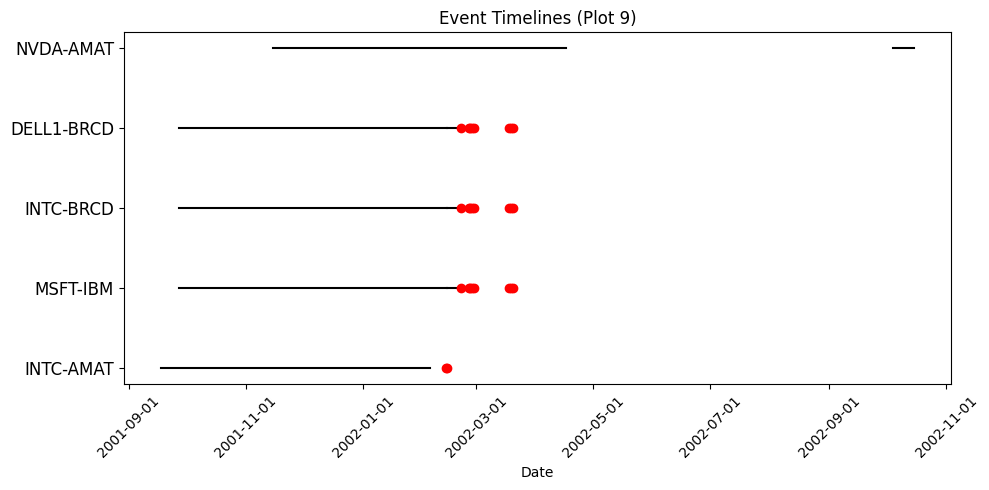

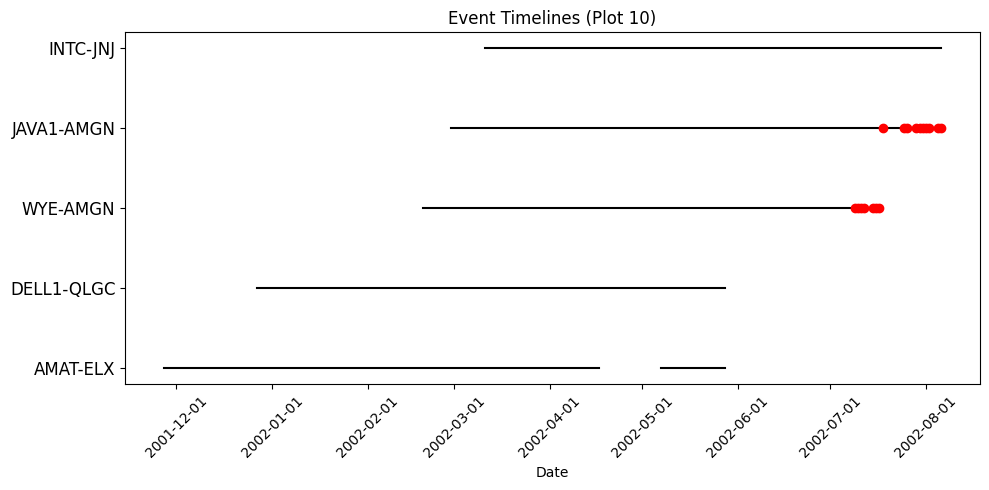

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (4).

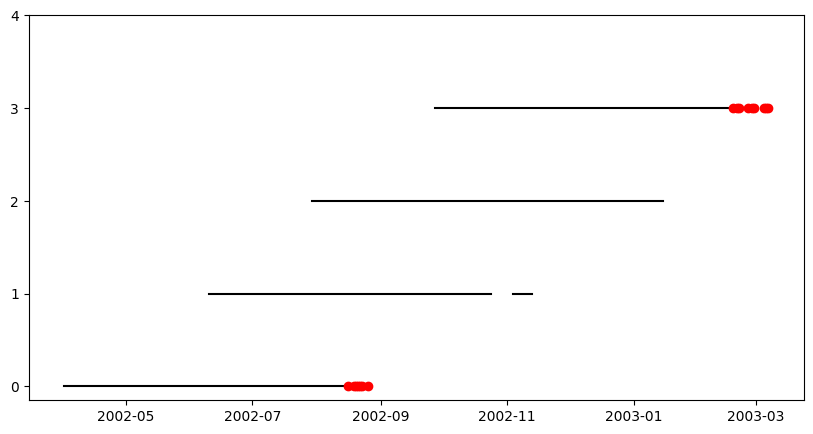

In [94]:
print_overall_display(results)